# Project 1: Market Risk — VaR, ES, and Copulas

**Names of all group members:**
- Piotr Kleymenov (piotr.kleymenov@epfl.ch)
- Mikhail Dubrovskiy (mikhail.dubrovskiy@epfl.ch)
- Margarita Pronina (margarita.pronina@epfl.ch)


---

## 0) Setup

Creates necessary folders and sets hyperparameters for the project.

In [ ]:
# If a package import fails, install it in your environment, e.g.:
# %pip install yfinance arch copulae statsmodels seaborn

import os
import numpy as np
import copulae
import pandas as pd
import scipy.stats as stats
from  scipy.signal import correlate
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import jarque_bera, probplot
import os
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# your own script with helper functions, if any
# import utils as U

# Locate the Project 1 directory to this notebook's working directory
PROJECT_DIR = Path.cwd()
DATA_DIR = PROJECT_DIR / 'data'
OUT_DIR = PROJECT_DIR / 'output'
for d in [DATA_DIR, OUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Parameters
TICKERS = ['AAPL', 'META', 'JPM']
START = '2023-01-01'
END = '2025-06-30'
WINDOW = 252                        # rolling/first-window length in periods (days)
ALPHAS = [0.95, 0.99]
np.random.seed(0)

print('Project dir:', PROJECT_DIR)
print('Output ->', OUT_DIR)

Project dir: /content
Output -> /content/output


Download and save Adjusted Close for the tickers over the given range into `data/` (CSV per ticker).

In [ ]:
import yfinance as yf

print('Downloading data to', DATA_DIR)
for t in TICKERS:
    print(f'  -> {t}')
    df = yf.download(t, start=START, end=END, progress=False, auto_adjust=False)
    if df.empty:
        print(f'     Warning: no data for {t}')
        continue
    out = df.reset_index()
    out = out[['Date', 'Adj Close']]
    out.to_csv(DATA_DIR / f'{t}.csv', index=False)
print('Done.')

  -> AAPL
  -> META
  -> JPM
Done.


Now, load the data back from CSVs

In [ ]:
files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith('.csv')]
frames = []
for f in files:
    p = os.path.join(DATA_DIR, f)
    df = pd.read_csv(p, parse_dates=['Date'])
    df = df[['Date', 'Adj Close']]
    # Coerce to numeric and drop malformed rows
    df['Adj Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')
    df = df.dropna(subset=['Date', 'Adj Close'])
    df = df.rename(columns={'Adj Close': f.split('.')[0]})
    df = df.set_index('Date').sort_index()
    frames.append(df)
prices = pd.concat(frames, axis=1).dropna(how='all')

print(prices.head(3))

                  META         JPM        AAPL
Date                                          
2023-01-03  123.975716  125.492226  123.211227
2023-01-04  126.589607  126.662422  124.482033
2023-01-05  126.162247  126.634384  123.161942


## 1) Empirical stylized facts


1.  Construct weekly log-returns for AAPL, MSFT, JPM; plot series and comment on trends/volatility.
2.  Estimate correlation functions of returns and absolute returns across assets and lags 0–25; comment.
3.  QQ plots vs Normal; perform Jarque–Bera test and discuss normality.


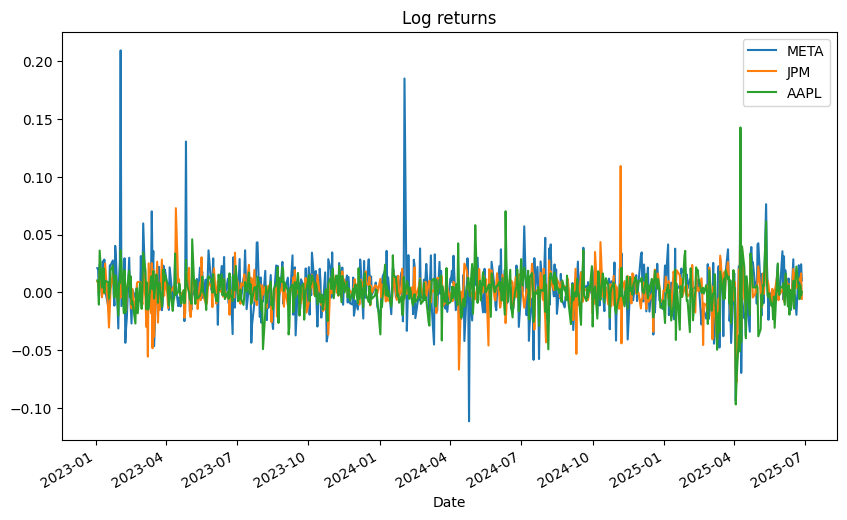

,count,mean,std,min,25%,50%,75%,max
META,623.0,0.002886,0.024038,-0.111617,-0.009277,0.001686,0.014007,0.209307
JPM,623.0,0.001328,0.014904,-0.077787,-0.005399,0.001973,0.008747,0.109254
AAPL,623.0,0.000799,0.016510,-0.097013,-0.007026,0.001578,0.008963,0.142617


In [ ]:
log_returns = np.log(prices).diff().fillna(method ='bfill') #in order to avoid  looking ahead bias we use bfill

log_returns.plot(title='Log returns', figsize=(10, 6))

plt.show()

log_returns.describe().T

In [ ]:
log_returns.corr()

,META,JPM,AAPL
META,1.000000,0.288400,0.464989
JPM,0.288400,1.000000,0.328048
AAPL,0.464989,0.328048,1.000000


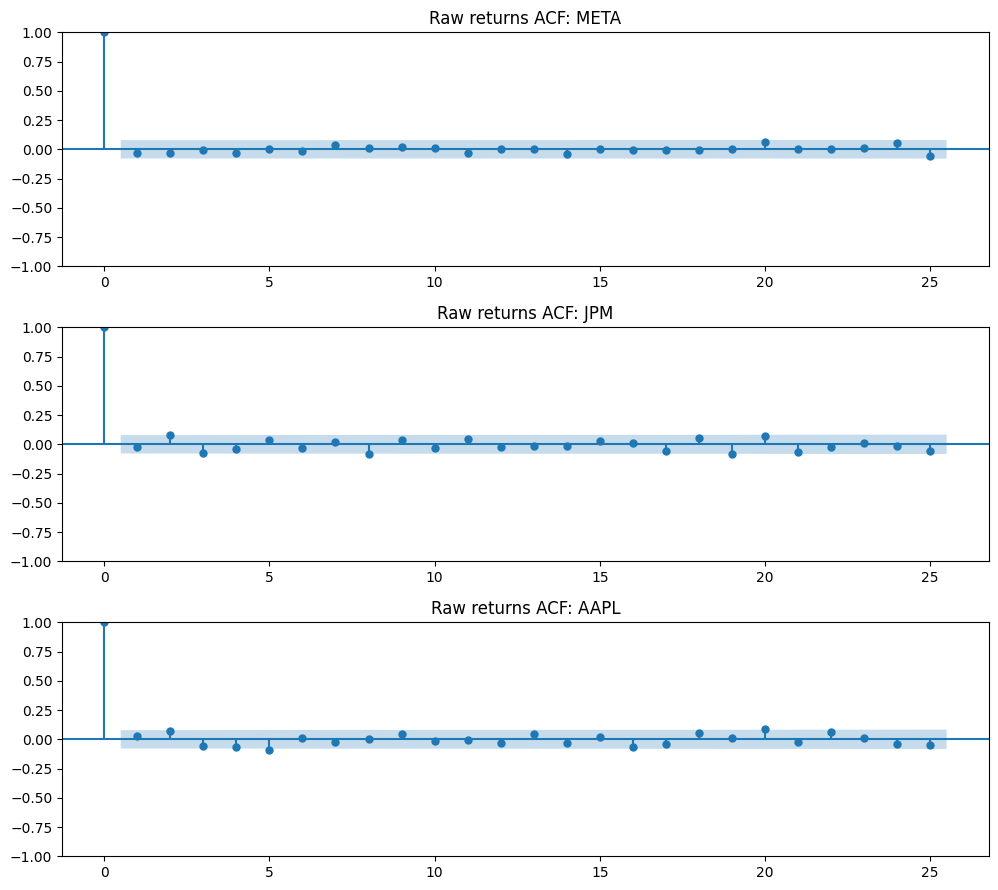

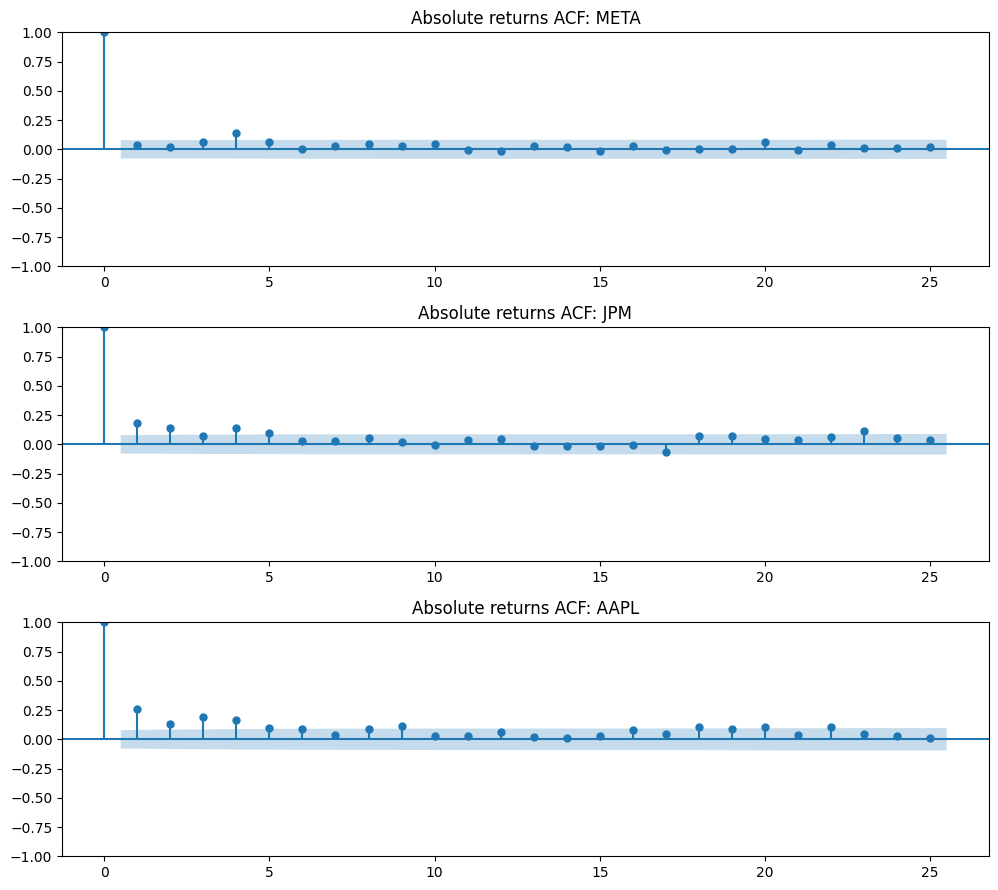

In [ ]:
MAX_LAG = 25
def plot_acf_series(df, max_lag, title_prefix):
    n = len(df.columns)
    fig, axes = plt.subplots(n, 1, figsize=(10, 3*n))
    if n == 1:
        axes = [axes]
    for ax, col in zip(axes, df.columns):
        plot_acf(df[col].dropna(), lags=max_lag, ax=ax, zero=True)
        ax.set_title(f"{title_prefix} ACF: {col}")
    plt.tight_layout()

plot_acf_series(log_returns, MAX_LAG, "Raw returns")
plot_acf_series(np.abs(log_returns), MAX_LAG, "Absolute returns")

In [ ]:
def cross_correlation_matrix_at_lags(df, max_lag):
    tickers = df.columns.tolist()
    results = {}
    for h in range(max_lag+1):
        mat = pd.DataFrame(index=tickers, columns=tickers, dtype=float)
        for i in tickers:
            for j in tickers:
                # Correlate df[i]_t with df[j]_(t-h)
                s1 = df[i].iloc[h:]
                s2 = df[j].shift(h).iloc[h:]
                valid = s1.notna() & s2.notna()
                if valid.sum() > 0:
                    mat.loc[i,j] = s1[valid].corr(s2[valid])
                else:
                    mat.loc[i,j] = np.nan
        results[h] = mat
    return results

cc_raw = cross_correlation_matrix_at_lags(log_returns, MAX_LAG)
cc_abs = cross_correlation_matrix_at_lags(np.abs(log_returns), MAX_LAG)

# Create output directory if it doesn't exist
OUT_DIR = PROJECT_DIR / 'output'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Save cross-correlation heatmaps
for h in range(MAX_LAG+1):
    plt.figure(figsize=(6,4))
    sns.heatmap(cc_raw[h].astype(float), annot=True, fmt=".3f", vmin=-1, vmax=1)
    plt.title(f"Cross-correlation (raw returns) lag={h}")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f'cross_corr_raw_lag_{h}.png', dpi=300, bbox_inches='tight')
    plt.close()

    plt.figure(figsize=(6,4))
    sns.heatmap(cc_abs[h].astype(float), annot=True, fmt=".3f", vmin=-1, vmax=1)
    plt.title(f"Cross-correlation (abs returns) lag={h}")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f'cross_corr_abs_lag_{h}.png', dpi=300, bbox_inches='tight')
    plt.close()

pairs = []
for i in range(len(TICKERS)):
    for j in range(len(TICKERS)):
        pair = (TICKERS[i], TICKERS[j])
        vals_raw = [cc_raw[h].iloc[i,j] for h in range(MAX_LAG+1)]
        vals_abs = [cc_abs[h].iloc[i,j] for h in range(MAX_LAG+1)]
        pairs.append({
            "pair": f"{pair[0]} vs {pair[1]}",
            **{f"raw_lag_{h}": vals_raw[h] for h in range(MAX_LAG+1)},
            **{f"abs_lag_{h}": vals_abs[h] for h in range(MAX_LAG+1)},
        })

# ========== 5) QQ-plots (against normal) and Jarque-Bera tests ==========
jb_results = []
for col in log_returns.columns:
    data = log_returns[col].dropna()
    plt.figure(figsize=(6,6))
    probplot(data, dist="norm", plot=plt)
    plt.title(f"QQ-plot vs Normal: {col}")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f'qq_plot_{col}.png', dpi=300, bbox_inches='tight')
    plt.close()

    jb_stat, jb_p = jarque_bera(data)
    jb_results.append({"ticker": col, "jb_stat": jb_stat, "jb_pvalue": jb_p, "n": len(data)})

print("Jarque-Bera results:\n", pd.DataFrame(jb_results))

# ========== 6) Save a few more diagnostic plots ==========
# Rolling volatility (e.g., 21-day)
rolling_window = 21
plt.figure(figsize=(12,6))
for col in log_returns.columns:
    plt.plot(log_returns[col].rolling(rolling_window).std(), label=col)
plt.title(f"Rolling {rolling_window}-day Volatility (std of log-returns)")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / 'rolling_volatility.png', dpi=300, bbox_inches='tight')
plt.close()

# Histogram of returns
plt.figure(figsize=(10,6))
for col in log_returns.columns:
    sns.histplot(log_returns[col], stat="density", label=col, kde=False, element="step", alpha=0.6)
plt.title("Histogram of daily log-returns (overlaid)")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / 'returns_histogram.png', dpi=300, bbox_inches='tight')
plt.close()

print(f"\nAll plots saved to: {OUT_DIR}")

Jarque-Bera results:
   ticker      jb_stat  jb_pvalue    n
0   META  7608.773299        0.0  623
1    JPM  2211.242684        0.0  623
2   AAPL  3628.813884        0.0  623

All plots saved to: /content/output


## 2) First-window modeling: VaR, ES, and distributions

Use the first estimation window W (weeks) on each asset separately with losses L = −R.
Compare:

- historical,
- Gaussian,
- Student-t,
- AR(p)+GARCH(1,1) with Normal/Student-t,
- Filtered Historical Simulation (FHS).

In [ ]:
# Parameters
W = 252
alpha_levels = [0.95, 0.99]

# Use loss convention: L_t = -R_t (right tail is risky)
def get_losses(returns_df, window_size=252):
    """Convert returns to losses for the first window"""
    losses = -returns_df.iloc[:window_size].copy()
    return losses

# 2.a) Historical Simulation
def historical_simulation_var_es(losses, alpha):
    """
    Compute VaR and ES using empirical distribution (Historical Simulation)
    """
    # Empirical quantile for VaR
    var = np.quantile(losses, alpha)
    # ES: average of losses exceeding VaR
    es = losses[losses >= var].mean()
    return var, es


# 2.b) Gaussian
def gaussian_var_es(losses, alpha):
    """
    Fit Gaussian distribution and compute VaR/ES using closed-form solutions
    """
    mu = losses.mean()
    sigma = losses.std(ddof=1)

    # Closed-form VaR: mu + sigma * z_alpha
    z_alpha = stats.norm.ppf(alpha)
    var = mu + sigma * z_alpha

    # Closed-form ES: mu + sigma * phi(z_alpha) / (1 - alpha)
    # where phi is the standard normal PDF
    es = mu + sigma * stats.norm.pdf(z_alpha) / (1 - alpha)

    return var, es, mu, sigma

# 2.c) Student-t
def studentt_var_es(losses, alpha):
    """
    Fit Student-t distribution using MLE and compute VaR/ES
    """
    # MLE for Student-t distribution
    params = stats.t.fit(losses)
    nu, mu, sigma = params  # degrees of freedom, location, scale

    # Closed-form VaR
    t_alpha = stats.t.ppf(alpha, nu)
    var = mu + sigma * t_alpha

    # Closed-form ES for Student-t
    t_pdf = stats.t.pdf(t_alpha, nu)
    es = mu + sigma * t_pdf * (nu + t_alpha**2) / ((1 - alpha) * (nu - 1))

    return var, es, nu, mu, sigma

# 2.d) Conditional Parametric (AR + GARCH) ---> https://arch.readthedocs.io/en/stable/univariate/introduction.html
# p = 0 based on ACF analysis
# GARCH model : Definition 13.4 Time Series
def fit_ar_garch(losses, ar_order):
    """
    Fit AR(p) + GARCH(1,1) model with Gaussian innovations
    Returns fitted model
    """
    # ARCH library expects returns (not losses), so we negate
    returns_for_arch = -losses

    # Fit AR(0) + GARCH(1,1)
    model = arch_model(returns_for_arch, vol='Garch', p=1, q=1,
                       mean='constant', lags=ar_order, dist='normal')
    fitted = model.fit(disp='off')

    return fitted

def conditional_var_es(fitted_model, alpha):
    """
    Compute 1-step-ahead VaR/ES using conditional mean and volatility forecasts
    """
    # Get 1-step-ahead forecasts
    forecast = fitted_model.forecast(horizon=1)
    mu_forecast = forecast.mean.iloc[-1, 0]  # conditional mean
    sigma_forecast = np.sqrt(forecast.variance.iloc[-1, 0])  # conditional volatility

    # Convert back to loss convention (negate the mean)
    mu_loss = -mu_forecast

    # Use Gaussian distribution with conditional parameters
    z_alpha = stats.norm.ppf(alpha)
    var = mu_loss + sigma_forecast * z_alpha
    es = mu_loss + sigma_forecast * stats.norm.pdf(z_alpha) / (1 - alpha)

    return var, es, mu_loss, sigma_forecast

# 2.e) Filtered Historical Simulation (FHS)
def filtered_historical_simulation(fitted_model, losses, alpha, M=1000):
    """
    FHS procedure: Bootstrap from standardized residuals
    """
    # Get residuals and conditional volatility from fitted model
    residuals = fitted_model.resid
    conditional_vol = fitted_model.conditional_volatility

    # Standardized residuals
    std_residuals = residuals / conditional_vol
    std_residuals = std_residuals.dropna()

    # Get 1-step-ahead conditional mean and volatility
    forecast = fitted_model.forecast(horizon=1)
    mu_forecast = forecast.mean.iloc[-1, 0]
    sigma_forecast = np.sqrt(forecast.variance.iloc[-1, 0])

    # Convert to loss convention
    mu_loss = -mu_forecast

    # Bootstrap: resample standardized residuals with replacement
    np.random.seed(42)  # for reproducibility
    bootstrapped_std_residuals = np.random.choice(std_residuals, size=M, replace=True)

    # Generate 1-step-ahead loss scenarios
    loss_scenarios = mu_loss + sigma_forecast * bootstrapped_std_residuals

    # Compute VaR and ES from bootstrapped distribution
    var = np.quantile(loss_scenarios, alpha)
    es = loss_scenarios[loss_scenarios >= var].mean()

    return var, es, loss_scenarios

# Main Analysis for Each Asset
def analyze_asset(ticker, returns_df, ar_order=0):
    """
    Perform all VaR/ES analyses for a single asset
    """
    print(f"\n{'='*60}")
    print(f"Analyzing {ticker}")
    print(f"{'='*60}")

    # Get losses for first window
    losses = get_losses(returns_df[[ticker]], W)[ticker]

    results = {}

    # Store fitted distributions for plotting
    fitted_dists = {}

    for alpha in alpha_levels:
        print(f"\nAlpha = {alpha}")
        results[alpha] = {}

        # a) Historical Simulation
        var_hs, es_hs = historical_simulation_var_es(losses, alpha)
        results[alpha]['HS'] = {'VaR': var_hs, 'ES': es_hs}
        print(f"  Historical Simulation: VaR = {var_hs:.4f}, ES = {es_hs:.4f}")

        # b) Gaussian
        var_g, es_g, mu_g, sigma_g = gaussian_var_es(losses, alpha)
        results[alpha]['Gaussian'] = {'VaR': var_g, 'ES': es_g}
        fitted_dists['Gaussian'] = (mu_g, sigma_g)
        print(f"  Gaussian: VaR = {var_g:.4f}, ES = {es_g:.4f}")

        # c) Student-t
        var_t, es_t, nu_t, mu_t, sigma_t = studentt_var_es(losses, alpha)
        results[alpha]['Student-t'] = {'VaR': var_t, 'ES': es_t}
        fitted_dists['Student-t'] = (nu_t, mu_t, sigma_t)
        print(f"  Student-t (nu={nu_t:.2f}): VaR = {var_t:.4f}, ES = {es_t:.4f}")

    # d) Conditional Parametric (fit once, use for both alphas)
    print(f"\nFitting AR(0) + GARCH(1,1) model...")
    fitted_ar_garch = fit_ar_garch(losses, ar_order)
    print(fitted_ar_garch.summary())

    for alpha in alpha_levels:
        var_cond, es_cond, mu_cond, sigma_cond = conditional_var_es(fitted_ar_garch, alpha)
        results[alpha]['AR-GARCH'] = {'VaR': var_cond, 'ES': es_cond}
        print(f"\nAlpha = {alpha}")
        print(f"  AR-GARCH: VaR = {var_cond:.4f}, ES = {es_cond:.4f}")
        print(f"  Conditional mean = {mu_cond:.4f}, Conditional vol = {sigma_cond:.4f}")

    # e) Filtered Historical Simulation
    for alpha in alpha_levels:
        var_fhs, es_fhs, scenarios = filtered_historical_simulation(
            fitted_ar_garch, losses, alpha, M=1000
        )
        results[alpha]['FHS'] = {'VaR': var_fhs, 'ES': es_fhs}
        print(f"\nAlpha = {alpha}")
        print(f"  FHS: VaR = {var_fhs:.4f}, ES = {es_fhs:.4f}")

    # Plot PDFs for comparison
    plot_pdfs(losses, fitted_dists, ticker)

    return results, fitted_ar_garch

# Plotting Function
def plot_pdfs(losses, fitted_dists, ticker):
    """
    Plot estimated PDFs for all fitted distributions
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Empirical histogram
    ax.hist(losses, bins=50, density=True, alpha=0.3, color='gray',
            label='Empirical (Histogram)')

    # Range for plotting
    x = np.linspace(losses.min(), losses.max(), 1000)

    # Gaussian
    mu_g, sigma_g = fitted_dists['Gaussian']
    pdf_gaussian = stats.norm.pdf(x, mu_g, sigma_g)
    ax.plot(x, pdf_gaussian, label='Gaussian', linewidth=2)

    # Student-t
    nu_t, mu_t, sigma_t = fitted_dists['Student-t']
    pdf_studentt = stats.t.pdf(x, nu_t, mu_t, sigma_t)
    ax.plot(x, pdf_studentt, label=f'Student-t (ν={nu_t:.1f})', linewidth=2)

    ax.set_xlabel('Loss', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title(f'Fitted Loss Distributions - {ticker}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()





Analyzing AAPL

Alpha = 0.95
  Historical Simulation: VaR = 0.0176, ES = 0.0268
  Gaussian: VaR = 0.0193, ES = 0.0247
  Student-t (nu=6.82): VaR = 0.0187, ES = 0.0263

Alpha = 0.99
  Historical Simulation: VaR = 0.0330, ES = 0.0407
  Gaussian: VaR = 0.0280, ES = 0.0323
  Student-t (nu=6.82): VaR = 0.0307, ES = 0.0391

Fitting AR(0) + GARCH(1,1) model...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                742.896
Distribution:                  Normal   AIC:                          -1477.79
Method:            Maximum Likelihood   BIC:                          -1463.67
                                        No. Observations:                  252
Date:                Thu, Nov 20 2025   Df Residuals:                      251
Time:      

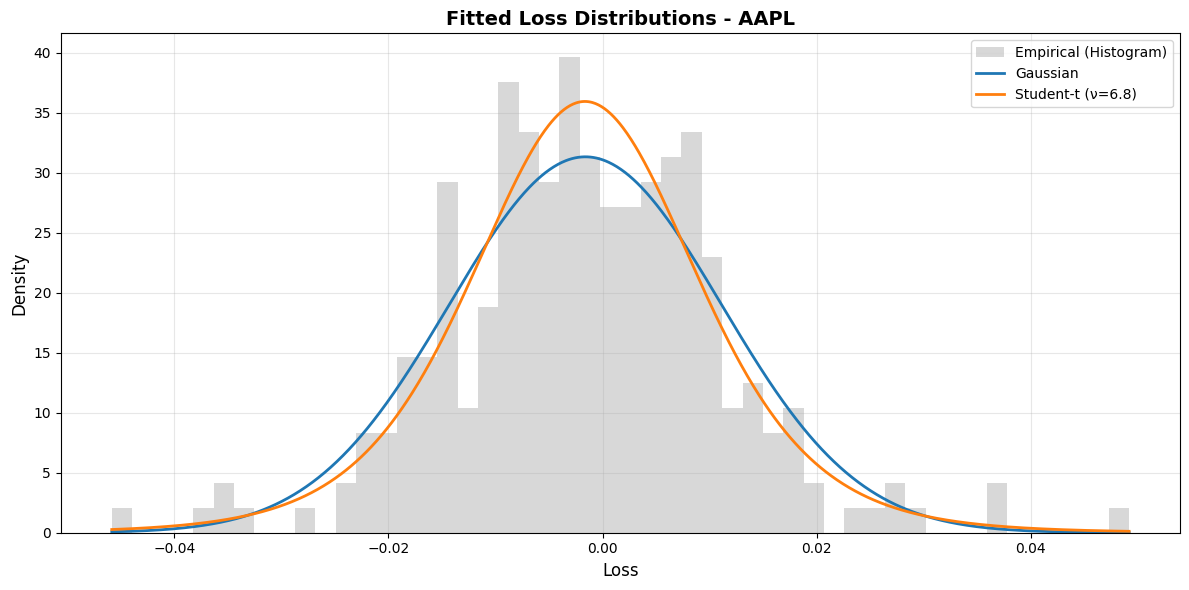


Analyzing META

Alpha = 0.95
  Historical Simulation: VaR = 0.0273, ES = 0.0359
  Gaussian: VaR = 0.0353, ES = 0.0453
  Student-t (nu=4.45): VaR = 0.0300, ES = 0.0453

Alpha = 0.99
  Historical Simulation: VaR = 0.0431, ES = 0.0446
  Gaussian: VaR = 0.0516, ES = 0.0597
  Student-t (nu=4.45): VaR = 0.0533, ES = 0.0733

Fitting AR(0) + GARCH(1,1) model...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   META   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                590.697
Distribution:                  Normal   AIC:                          -1173.39
Method:            Maximum Likelihood   BIC:                          -1159.28
                                        No. Observations:                  252
Date:                Thu, Nov 20 2025   Df Residuals:                      251
Time:      

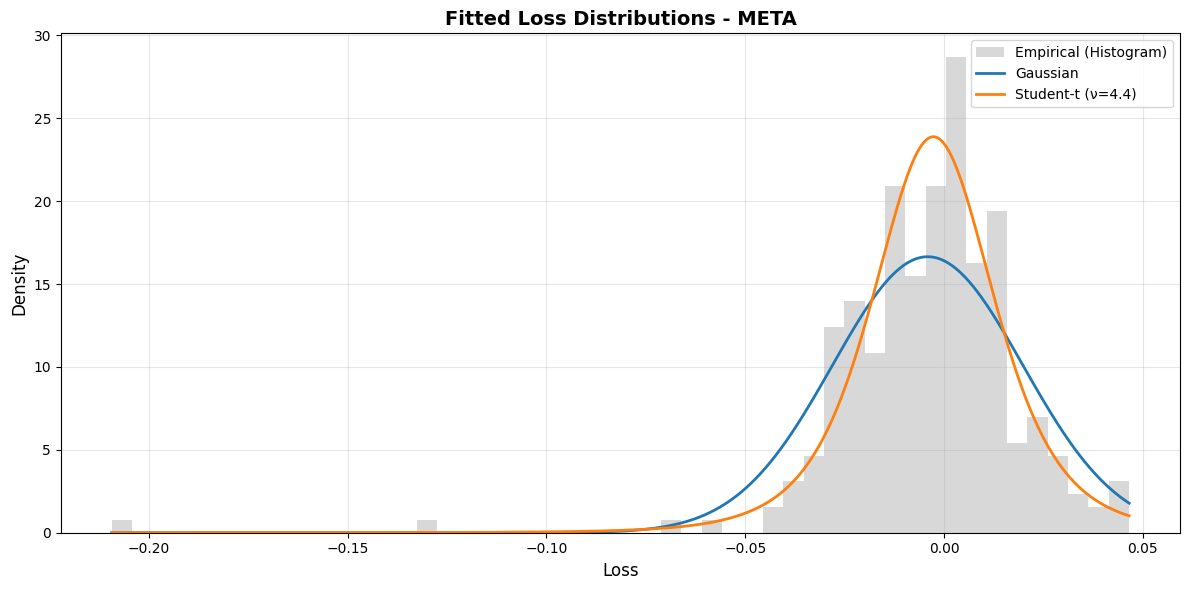


Analyzing JPM

Alpha = 0.95
  Historical Simulation: VaR = 0.0183, ES = 0.0303
  Gaussian: VaR = 0.0203, ES = 0.0258
  Student-t (nu=3.54): VaR = 0.0179, ES = 0.0287

Alpha = 0.99
  Historical Simulation: VaR = 0.0376, ES = 0.0475
  Gaussian: VaR = 0.0292, ES = 0.0336
  Student-t (nu=3.54): VaR = 0.0340, ES = 0.0499

Fitting AR(0) + GARCH(1,1) model...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    JPM   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                748.639
Distribution:                  Normal   AIC:                          -1489.28
Method:            Maximum Likelihood   BIC:                          -1475.16
                                        No. Observations:                  252
Date:                Thu, Nov 20 2025   Df Residuals:                      251
Time:       

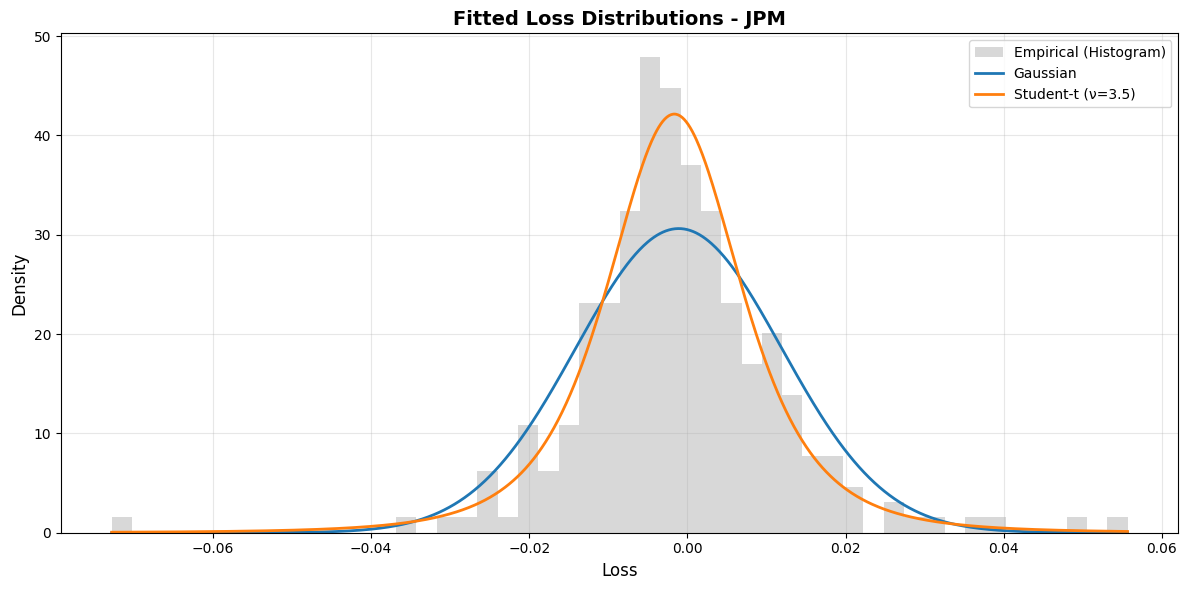


SUMMARY TABLE
Ticker  Alpha    Method      VaR       ES
  AAPL   0.95        HS 0.017587 0.026807
  AAPL   0.95  Gaussian 0.019338 0.024657
  AAPL   0.95 Student-t 0.018701 0.026300
  AAPL   0.95  AR-GARCH 0.019525 0.024883
  AAPL   0.95       FHS 0.018838 0.025989
  AAPL   0.99        HS 0.032997 0.040701
  AAPL   0.99  Gaussian 0.028013 0.032326
  AAPL   0.99 Student-t 0.030660 0.039105
  AAPL   0.99  AR-GARCH 0.028262 0.032607
  AAPL   0.99       FHS 0.031474 0.040433
  META   0.95        HS 0.027310 0.035920
  META   0.95  Gaussian 0.035295 0.045306
  META   0.95 Student-t 0.030041 0.045308
  META   0.95  AR-GARCH 0.032040 0.041079
  META   0.95       FHS 0.021032 0.039003
  META   0.99        HS 0.043077 0.044618
  META   0.99  Gaussian 0.051623 0.059742
  META   0.99 Student-t 0.053340 0.073304
  META   0.99  AR-GARCH 0.046782 0.054113
  META   0.99       FHS 0.036588 0.080092
   JPM   0.95        HS 0.018300 0.030295
   JPM   0.95  Gaussian 0.020333 0.025777
   JPM   0.95 Stude

In [ ]:
ar_orders = {'AAPL': 0, 'META': 0, 'JPM': 0}

all_results = {}
all_models = {}

for ticker in ['AAPL', 'META', 'JPM']:
    results, model = analyze_asset(ticker, log_returns, ar_order=ar_orders[ticker])
    all_results[ticker] = results
    all_models[ticker] = model

# Create summary table
summary_data = []
for ticker in ['AAPL', 'META', 'JPM']:
    for alpha in [0.95, 0.99]:
        for method in ['HS', 'Gaussian', 'Student-t', 'AR-GARCH', 'FHS']:
            row = {
                'Ticker': ticker,
                'Alpha': alpha,
                'Method': method,
                'VaR': all_results[ticker][alpha][method]['VaR'],
                'ES': all_results[ticker][alpha][method]['ES']
            }
            summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(summary_df.to_string(index=False))

## 3) Rolling-window backtesting of VaR and ES

Use a rolling window of size W to produce 1-step-ahead VaR/ES at 95% and 99% for each method in Exercise 2. Then, implement the following statistical tests:

- VaR backtests: Kupiec POF and Christoffersen independence tests.
- ES backtest: Acerbi–Székely Z1 test.

In [ ]:
def rolling_window_backtest(returns_df, ticker, W=252, alpha_levels=[0.95, 0.99], ar_order=0):
    """
    Perform rolling window backtesting for all methods

    Parameters:
    - returns_df: DataFrame with returns
    - ticker: asset ticker
    - W: window size (252)
    - alpha_levels: confidence levels
    - ar_order: order for AR model

    Returns:
    - Dictionary with forecasts and realized losses for each method
    """
    returns = returns_df[ticker].dropna()
    T = len(returns)

    # Initialize storage for forecasts
    forecasts = {
        'HS': {alpha: {'VaR': [], 'ES': []} for alpha in alpha_levels},
        'Gaussian': {alpha: {'VaR': [], 'ES': []} for alpha in alpha_levels},
        'Student-t': {alpha: {'VaR': [], 'ES': []} for alpha in alpha_levels},
        'AR-GARCH': {alpha: {'VaR': [], 'ES': []} for alpha in alpha_levels},
        'FHS': {alpha: {'VaR': [], 'ES': []} for alpha in alpha_levels}
    }

    realized_losses = []
    forecast_dates = []

    # Rolling window loop
    for t in range(W, T):
        # Get window data: from t-W+1 to t
        window_returns = returns.iloc[t-W+1:t+1]
        window_losses = -window_returns  # Loss convention

        # Realized loss at t+1 (out-of-sample)
        if t + 1 < T:
            realized_loss = -returns.iloc[t+1]
            realized_losses.append(realized_loss)
            forecast_dates.append(returns.index[t+1])
        else:
            break

        # ========== Historical Simulation ==========
        for alpha in alpha_levels:
            var_hs = np.quantile(window_losses, alpha)
            es_hs = window_losses[window_losses >= var_hs].mean()
            forecasts['HS'][alpha]['VaR'].append(var_hs)
            forecasts['HS'][alpha]['ES'].append(es_hs)

        # ========== Gaussian ==========
        mu = window_losses.mean()
        sigma = window_losses.std(ddof=1)
        for alpha in alpha_levels:
            z_alpha = stats.norm.ppf(alpha)
            var_g = mu + sigma * z_alpha
            es_g = mu + sigma * stats.norm.pdf(z_alpha) / (1 - alpha)
            forecasts['Gaussian'][alpha]['VaR'].append(var_g)
            forecasts['Gaussian'][alpha]['ES'].append(es_g)

        # ========== Student-t ==========
        params = stats.t.fit(window_losses)
        nu, mu_t, sigma_t = params
        for alpha in alpha_levels:
            t_alpha = stats.t.ppf(alpha, nu)
            var_t = mu_t + sigma_t * t_alpha
            t_pdf = stats.t.pdf(t_alpha, nu)
            es_t = mu_t + sigma_t * t_pdf * (nu + t_alpha**2) / ((1 - alpha) * (nu - 1))
            forecasts['Student-t'][alpha]['VaR'].append(var_t)
            forecasts['Student-t'][alpha]['ES'].append(es_t)

        # ========== AR-GARCH ==========
        try:
            # Fit AR(0) + GARCH(1,1)
            model = arch_model(-window_losses, vol='Garch', p=1, q=1,
                             mean='constant', lags=ar_order, dist='normal')
            fitted = model.fit(disp='off', show_warning=True)

            # 1-step-ahead forecast
            forecast = fitted.forecast(horizon=1)
            mu_forecast = forecast.mean.iloc[-1, 0]
            sigma_forecast = np.sqrt(forecast.variance.iloc[-1, 0])
            if fitted.convergence_flag != 0:
                print(mu_forecast, sigma_forecast, fitted.convergence_flag)
                mu_forecast = np.nan
                sigma_forecast = np.nan
            mu_loss = -mu_forecast

            for alpha in alpha_levels:
                z_alpha = stats.norm.ppf(alpha)
                var_cond = mu_loss + sigma_forecast * z_alpha
                es_cond = mu_loss + sigma_forecast * stats.norm.pdf(z_alpha) / (1 - alpha)
                forecasts['AR-GARCH'][alpha]['VaR'].append(var_cond)
                forecasts['AR-GARCH'][alpha]['ES'].append(es_cond)

            # ========== FHS ==========
            residuals = fitted.resid
            conditional_vol = fitted.conditional_volatility
            std_residuals = (residuals / conditional_vol).dropna()

            # Bootstrap
            M = 1000
            np.random.seed(t)  # Different seed for each window
            bootstrapped = np.random.choice(std_residuals, size=M, replace=True)
            loss_scenarios = mu_loss + sigma_forecast * bootstrapped

            for alpha in alpha_levels:
                var_fhs = np.quantile(loss_scenarios, alpha)
                es_fhs = loss_scenarios[loss_scenarios >= var_fhs].mean()
                forecasts['FHS'][alpha]['VaR'].append(var_fhs)
                forecasts['FHS'][alpha]['ES'].append(es_fhs)

        except Exception as e:
            # If model fails, use NaN
            for alpha in alpha_levels:
                forecasts['AR-GARCH'][alpha]['VaR'].append(np.nan)
                forecasts['AR-GARCH'][alpha]['ES'].append(np.nan)
                forecasts['FHS'][alpha]['VaR'].append(np.nan)
                forecasts['FHS'][alpha]['ES'].append(np.nan)

    return forecasts, realized_losses, forecast_dates

def kupiec_pof_test(violations, T, alpha):
    """
    Kupiec (1995) Proportion-of-Failures test

    Parameters:
    - violations: array of violation indicators (1 if violation, 0 otherwise)
    - T: number of observations
    - alpha: nominal coverage level

    Returns:
    - LR_POF: test statistic
    - p_value: p-value
    - N: number of violations
    - p_hat: empirical violation rate
    """
    N = np.sum(violations)
    p_hat = N / T
    p = 1 - alpha  # Nominal violation probability

    # Avoid log(0)
    if N == 0:
        LR_POF = -2 * (T * np.log(1 - p))
    elif N == T:
        LR_POF = -2 * (T * np.log(p))
    else:
        L0 = (1 - p)**(T - N) * p**N
        L1 = (1 - p_hat)**(T - N) * p_hat**N
        LR_POF = -2 * np.log(L0 / L1)

    # p-value from chi-squared(1)
    p_value = 1 - stats.chi2.cdf(LR_POF, df=1)

    return LR_POF, p_value, N, p_hat

def christoffersen_test(violations, T, alpha):
    """
    Christoffersen (1998) Conditional Coverage test

    Returns:
    - LR_ind: independence test statistic
    - LR_cc: conditional coverage test statistic
    - p_value_ind: p-value for independence test
    - p_value_cc: p-value for conditional coverage test
    """
    # First compute POF test
    LR_POF, _, _, _ = kupiec_pof_test(violations, T, alpha)

    # Count transitions
    N00 = N01 = N10 = N11 = 0

    for i in range(len(violations) - 1):
        if violations[i] == 0 and violations[i+1] == 0:
            N00 += 1
        elif violations[i] == 0 and violations[i+1] == 1:
            N01 += 1
        elif violations[i] == 1 and violations[i+1] == 0:
            N10 += 1
        elif violations[i] == 1 and violations[i+1] == 1:
            N11 += 1

    # Estimate transition probabilities
    if N00 + N01 > 0:
        pi_0 = N01 / (N00 + N01)
    else:
        pi_0 = 0

    if N10 + N11 > 0:
        pi_1 = N11 / (N10 + N11)
    else:
        pi_1 = 0

    p_hat = (N01 + N11) / (N00 + N01 + N10 + N11)

    # Likelihood for independence test
    if pi_0 == 0 or pi_0 == 1 or pi_1 == 0 or pi_1 == 1:
        LR_ind = 0
    else:
        L1 = ((1 - pi_0)**N00) * (pi_0**N01) * ((1 - pi_1)**N10) * (pi_1**N11)
        L0 = ((1 - p_hat)**(N00 + N10)) * (p_hat**(N01 + N11))
        LR_ind = -2 * np.log(L0 / L1)

    # Conditional coverage test
    LR_cc = LR_POF + LR_ind

    # p-values
    p_value_ind = 1 - stats.chi2.cdf(LR_ind, df=1)
    p_value_cc = 1 - stats.chi2.cdf(LR_cc, df=2)

    return LR_ind, LR_cc, p_value_ind, p_value_cc

def acerbi_szekely_z1_test(realized_losses, var_forecasts, es_forecasts, M=1000):
    """
    Acerbi-Székely (2014) Z1 test for ES backtesting

    Parameters:
    - realized_losses: array of realized losses
    - var_forecasts: array of VaR forecasts
    - es_forecasts: array of ES forecasts
    - M: number of bootstrap simulations

    Returns:
    - Z1_obs: observed test statistic
    - p_value: one-sided p-value
    """
    realized_losses = np.array(realized_losses)
    var_forecasts = np.array(var_forecasts)
    es_forecasts = np.array(es_forecasts)

    # Compute violation indicators
    violations = (realized_losses > var_forecasts).astype(int)
    N = np.sum(violations)

    if N == 0:
        return np.nan, np.nan  # Test is inconclusive

    # Observed Z1 statistic
    Z1_obs = (1 / N) * np.sum((realized_losses[violations == 1] /
                                es_forecasts[violations == 1])) - 1

    # Simulate null distribution
    Z1_simulated = []

    for m in range(M):
        # Generate artificial losses from the model's predictive distribution
        # Under the null, L_t ~ distribution with correct VaR and ES
        # We simulate from a distribution where VaR and ES are correct

        # Simple approach: simulate from exponential distribution beyond VaR
        # such that ES is correct
        simulated_losses = np.zeros(len(realized_losses))
        simulated_violations = np.zeros(len(realized_losses))

        for t in range(len(realized_losses)):
            # Simulate from distribution with correct VaR and ES
            # Use exponential tail beyond VaR
            u = np.random.uniform(0, 1)
            if u > (1 - (1 - 0.95)):
                # Simulate from exponential such that ES is correct
                # For exponential: ES = VaR + scale
                scale = max(es_forecasts[t] - var_forecasts[t], 0)
                simulated_losses[t] = var_forecasts[t] + np.random.exponential(scale)
                simulated_violations[t] = 1
            else:
                # No violation
                simulated_losses[t] = var_forecasts[t] * np.random.uniform(0, 1)

        N_sim = np.sum(simulated_violations)
        if N_sim > 0:
            Z1_sim = (1 / N_sim) * np.sum((simulated_losses[simulated_violations == 1] /
                                           es_forecasts[simulated_violations == 1])) - 1
            Z1_simulated.append(Z1_sim)

    # One-sided p-value
    Z1_simulated = np.array(Z1_simulated)
    p_value = np.mean(Z1_simulated >= Z1_obs)

    return Z1_obs, p_value

def backtest_asset(returns_df, ticker, W=252, alpha_primary=0.95, ar_order=0):
    """
    Complete backtesting analysis for one asset
    """
    print(f"\n{'='*80}")
    print(f"BACKTESTING {ticker}")
    print(f"{'='*80}\n")

    # Get forecasts
    print("Generating rolling window forecasts...")
    forecasts, realized_losses, forecast_dates = rolling_window_backtest(
        returns_df, ticker, W=W, alpha_levels=[0.95, 0.99], ar_order=ar_order
    )

    T_out = len(realized_losses)
    print(f"Out-of-sample period: {T_out} observations\n")

    # Results storage
    backtest_results = {}

    methods = ['HS', 'Gaussian', 'Student-t', 'AR-GARCH', 'FHS']

    for method in methods:
        print(f"\n{'-'*60}")
        print(f"Method: {method}")
        print(f"{'-'*60}")

        backtest_results[method] = {}

        for alpha in [0.95, 0.99]:
            print(f"\nAlpha = {alpha}")

            var_fc = np.array(forecasts[method][alpha]['VaR'])
            es_fc = np.array(forecasts[method][alpha]['ES'])

            # Remove NaN values if any
            valid = ~(np.isnan(var_fc) | np.isnan(es_fc))
            var_fc_valid = var_fc[valid]
            es_fc_valid = es_fc[valid]
            realized_valid = np.array(realized_losses)[valid]
            T_valid = len(realized_valid)

            if T_valid == 0:
                print(f"  No valid forecasts for {method}")
                continue

            # Compute violations
            violations = (realized_valid > var_fc_valid).astype(int)

            # === POF Test ===
            LR_POF, p_pof, N, p_hat = kupiec_pof_test(violations, T_valid, alpha)
            print(f"\n  Kupiec POF Test:")
            print(f"    Violations: {N}/{T_valid} ({p_hat:.4f})")
            print(f"    Expected: {(1-alpha):.4f}")
            print(f"    LR_POF = {LR_POF:.4f}, p-value = {p_pof:.4f}")
            print(f"    Result: {'REJECT' if p_pof < 0.05 else 'PASS'} (α=0.05)")

            # === Christoffersen Test ===
            LR_ind, LR_cc, p_ind, p_cc = christoffersen_test(violations, T_valid, alpha)
            print(f"\n  Christoffersen Tests:")
            print(f"    Independence: LR_ind = {LR_ind:.4f}, p-value = {p_ind:.4f}")
            print(f"      Result: {'REJECT (clustering)' if p_ind < 0.05 else 'PASS'}")
            print(f"    Conditional Coverage: LR_cc = {LR_cc:.4f}, p-value = {p_cc:.4f}")
            print(f"      Result: {'REJECT' if p_cc < 0.05 else 'PASS'}")

            # === Acerbi-Székely Z1 Test (only for primary alpha) ===
            if alpha == alpha_primary:
                print(f"\n  Acerbi-Székely Z1 ES Test:")
                Z1_obs, p_z1 = acerbi_szekely_z1_test(realized_valid, var_fc_valid,
                                                       es_fc_valid, M=1000)
                if not np.isnan(Z1_obs):
                    print(f"    Z1 = {Z1_obs:.4f}, p-value = {p_z1:.4f}")
                    print(f"    Result: {'REJECT (ES underestimated)' if p_z1 < 0.05 else 'PASS'}")
                    print(f"    Interpretation: {'Tail losses exceed ES forecasts' if Z1_obs > 0 else 'ES forecasts adequate'}")
                else:
                    print(f"    Test inconclusive (no violations)")

                # Store results
                backtest_results[method][alpha] = {
                    'N': N, 'p_hat': p_hat,
                    'LR_POF': LR_POF, 'p_pof': p_pof,
                    'LR_ind': LR_ind, 'p_ind': p_ind,
                    'LR_cc': LR_cc, 'p_cc': p_cc,
                    'Z1': Z1_obs, 'p_z1': p_z1
                }
            else:
                backtest_results[method][alpha] = {
                    'N': N, 'p_hat': p_hat,
                    'LR_POF': LR_POF, 'p_pof': p_pof,
                    'LR_ind': LR_ind, 'p_ind': p_ind,
                    'LR_cc': LR_cc, 'p_cc': p_cc
                }

    # === Plot VaR forecasts vs realized losses (primary alpha only) ===
    plot_var_forecasts(forecast_dates, realized_losses, forecasts,
                       ticker, alpha=alpha_primary)

    return backtest_results, forecasts, realized_losses, forecast_dates

def plot_var_forecasts(dates, realized_losses, forecasts, ticker, alpha=0.95):
    """
    Plot VaR forecasts along with realized losses
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.flatten()

    methods = ['HS', 'Gaussian', 'Student-t', 'AR-GARCH', 'FHS']

    for idx, method in enumerate(methods):
        ax = axes[idx]

        var_fc = forecasts[method][alpha]['VaR']

        # Plot realized losses
        ax.plot(dates, realized_losses, label='Realized Loss',
                alpha=0.6, linewidth=0.8, color='black')

        # Plot VaR forecast
        ax.plot(dates, var_fc, label=f'VaR {int(alpha*100)}%',
                color='red', linewidth=1.5, linestyle='--')

        # Highlight violations
        violations = np.array(realized_losses) > np.array(var_fc)
        violation_dates = np.array(dates)[violations]
        violation_losses = np.array(realized_losses)[violations]
        ax.scatter(violation_dates, violation_losses, color='red',
                  s=20, zorder=5, label='Violations')

        ax.set_title(f'{method}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel('Loss', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

    # Remove extra subplot
    fig.delaxes(axes[5])

    plt.suptitle(f'VaR Forecasts vs Realized Losses - {ticker} (α={alpha})',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"output/{ticker}-{alpha}-simple_forecast.png", dpi=300)
    plt.show()



BACKTESTING AAPL

Generating rolling window forecasts...
Out-of-sample period: 370 observations


------------------------------------------------------------
Method: HS
------------------------------------------------------------

Alpha = 0.95

  Kupiec POF Test:
    Violations: 34/370 (0.0919)
    Expected: 0.0500
    LR_POF = 11.0779, p-value = 0.0009
    Result: REJECT (α=0.05)

  Christoffersen Tests:
    Independence: LR_ind = 4.5826, p-value = 0.0323
      Result: REJECT (clustering)
    Conditional Coverage: LR_cc = 15.6604, p-value = 0.0004
      Result: REJECT

  Acerbi-Székely Z1 ES Test:
    Z1 = 0.0438, p-value = 0.2660
    Result: PASS
    Interpretation: Tail losses exceed ES forecasts

Alpha = 0.99

  Kupiec POF Test:
    Violations: 7/370 (0.0189)
    Expected: 0.0100
    LR_POF = 2.3559, p-value = 0.1248
    Result: PASS (α=0.05)

  Christoffersen Tests:
    Independence: LR_ind = 2.5345, p-value = 0.1114
      Result: PASS
    Conditional Coverage: LR_cc = 4.8904, p

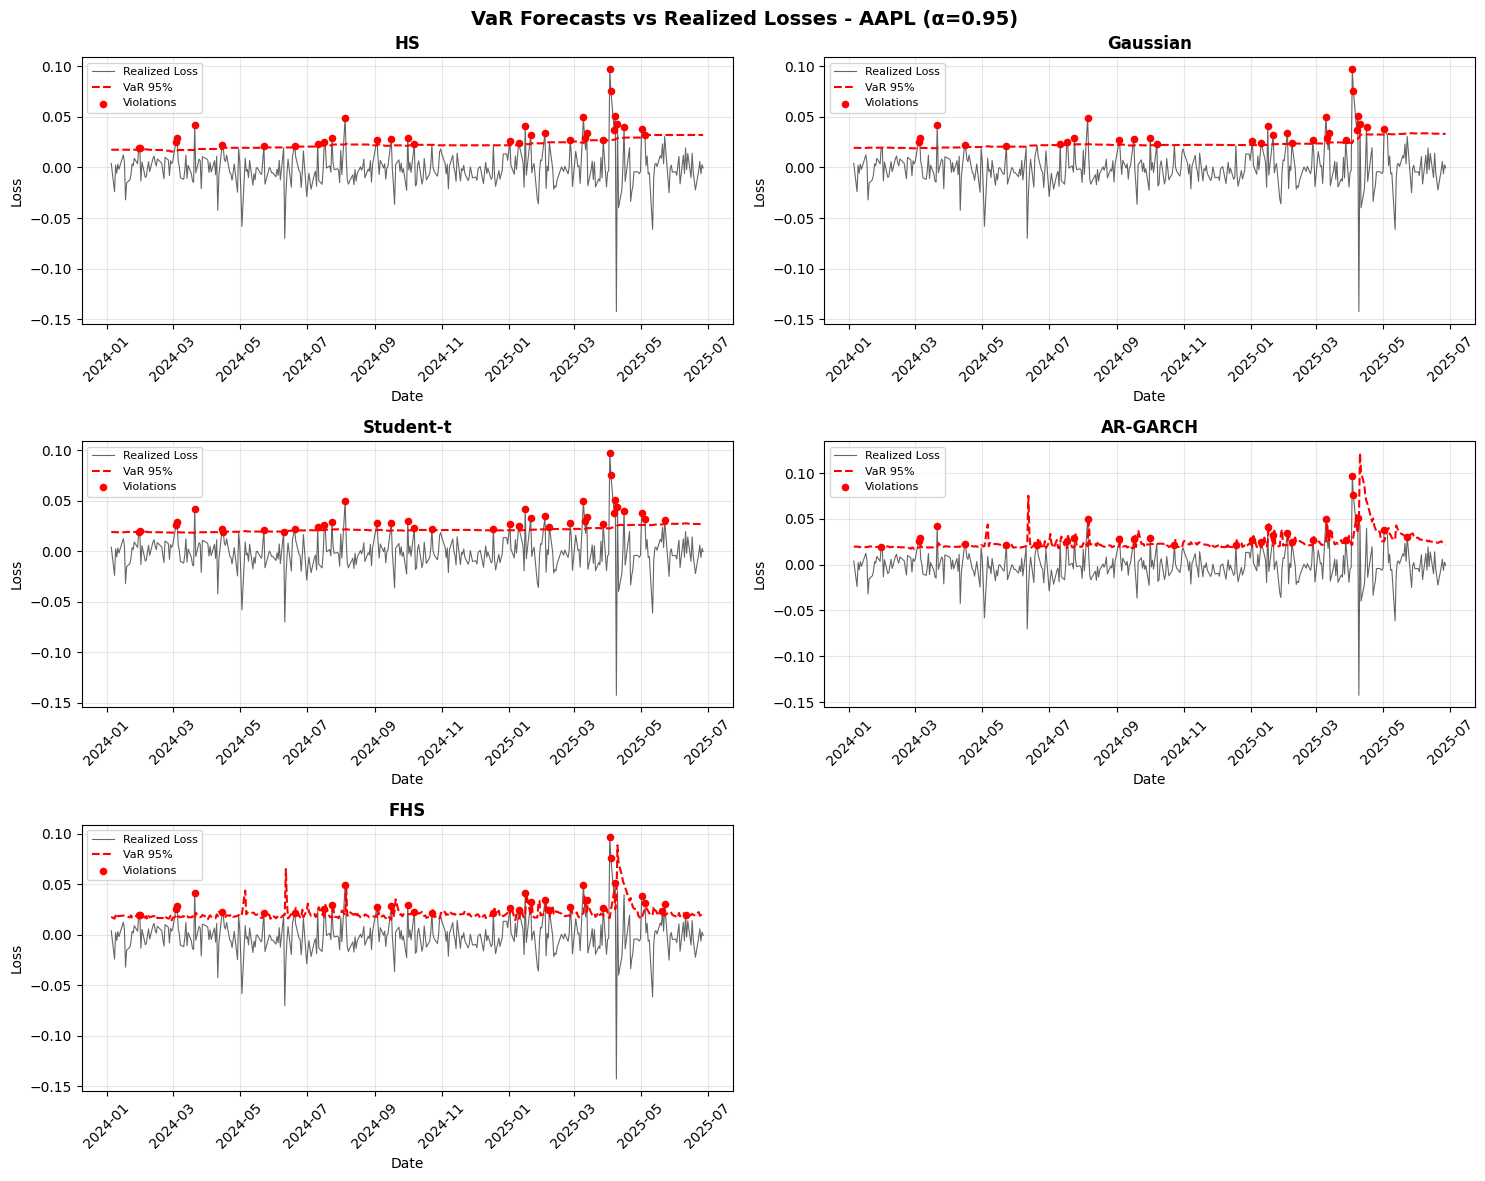


BACKTESTING META

Generating rolling window forecasts...
Out-of-sample period: 370 observations


------------------------------------------------------------
Method: HS
------------------------------------------------------------

Alpha = 0.95

  Kupiec POF Test:
    Violations: 23/370 (0.0622)
    Expected: 0.0500
    LR_POF = 1.0731, p-value = 0.3002
    Result: PASS (α=0.05)

  Christoffersen Tests:
    Independence: LR_ind = 0.2300, p-value = 0.6315
      Result: PASS
    Conditional Coverage: LR_cc = 1.3032, p-value = 0.5212
      Result: PASS

  Acerbi-Székely Z1 ES Test:
    Z1 = 0.0896, p-value = 0.1530
    Result: PASS
    Interpretation: Tail losses exceed ES forecasts

Alpha = 0.99

  Kupiec POF Test:
    Violations: 7/370 (0.0189)
    Expected: 0.0100
    LR_POF = 2.3559, p-value = 0.1248
    Result: PASS (α=0.05)

  Christoffersen Tests:
    Independence: LR_ind = 0.0000, p-value = 1.0000
      Result: PASS
    Conditional Coverage: LR_cc = 2.3559, p-value = 0.3079
     

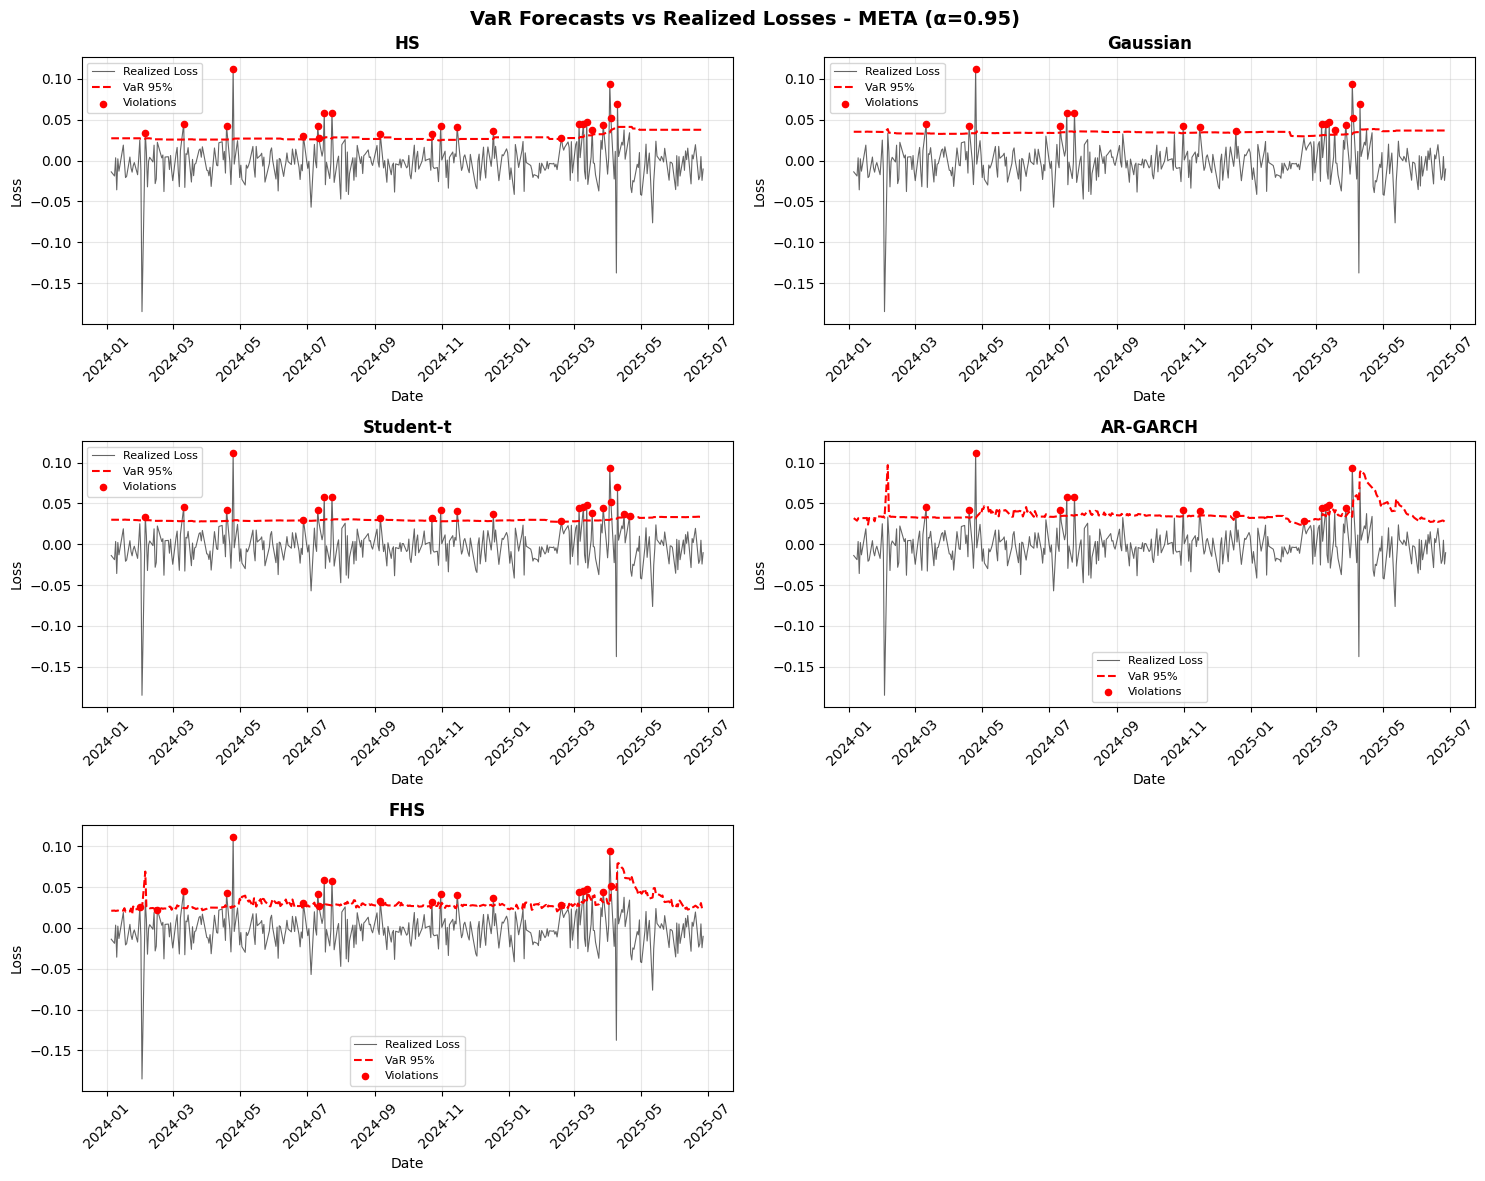


BACKTESTING JPM

Generating rolling window forecasts...


/tmp/ipython-input-1872848287.py:77: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  fitted = model.fit(disp='off', show_warning=True)
/tmp/ipython-input-1872848287.py:77: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  fitted = model.fit(disp='off', show_warning=True)


-0.08033592464701882 0.08216048270401263 4
-12.90341402794362 12.907248025266535 4


/tmp/ipython-input-1872848287.py:77: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  fitted = model.fit(disp='off', show_warning=True)


0.001373960897949841 0.011994257806745758 8


/tmp/ipython-input-1872848287.py:77: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  fitted = model.fit(disp='off', show_warning=True)


0.0003797726289826402 0.014928043235563657 8


/tmp/ipython-input-1872848287.py:77: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  fitted = model.fit(disp='off', show_warning=True)


0.0011366402378257493 0.014549790922171518 8


/tmp/ipython-input-1872848287.py:77: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  fitted = model.fit(disp='off', show_warning=True)


0.0022442202282978154 0.02333789318328696 8
Out-of-sample period: 370 observations


------------------------------------------------------------
Method: HS
------------------------------------------------------------

Alpha = 0.95

  Kupiec POF Test:
    Violations: 24/370 (0.0649)
    Expected: 0.0500
    LR_POF = 1.5801, p-value = 0.2087
    Result: PASS (α=0.05)

  Christoffersen Tests:
    Independence: LR_ind = 3.2188, p-value = 0.0728
      Result: PASS
    Conditional Coverage: LR_cc = 4.7989, p-value = 0.0908
      Result: PASS

  Acerbi-Székely Z1 ES Test:
    Z1 = 0.1545, p-value = 0.1010
    Result: PASS
    Interpretation: Tail losses exceed ES forecasts

Alpha = 0.99

  Kupiec POF Test:
    Violations: 8/370 (0.0216)
    Expected: 0.0100
    LR_POF = 3.7884, p-value = 0.0516
    Result: PASS (α=0.05)

  Christoffersen Tests:
    Independence: LR_ind = 2.0337, p-value = 0.1538
      Result: PASS
    Conditional Coverage: LR_cc = 5.8221, p-value = 0.0544
      Result: PASS


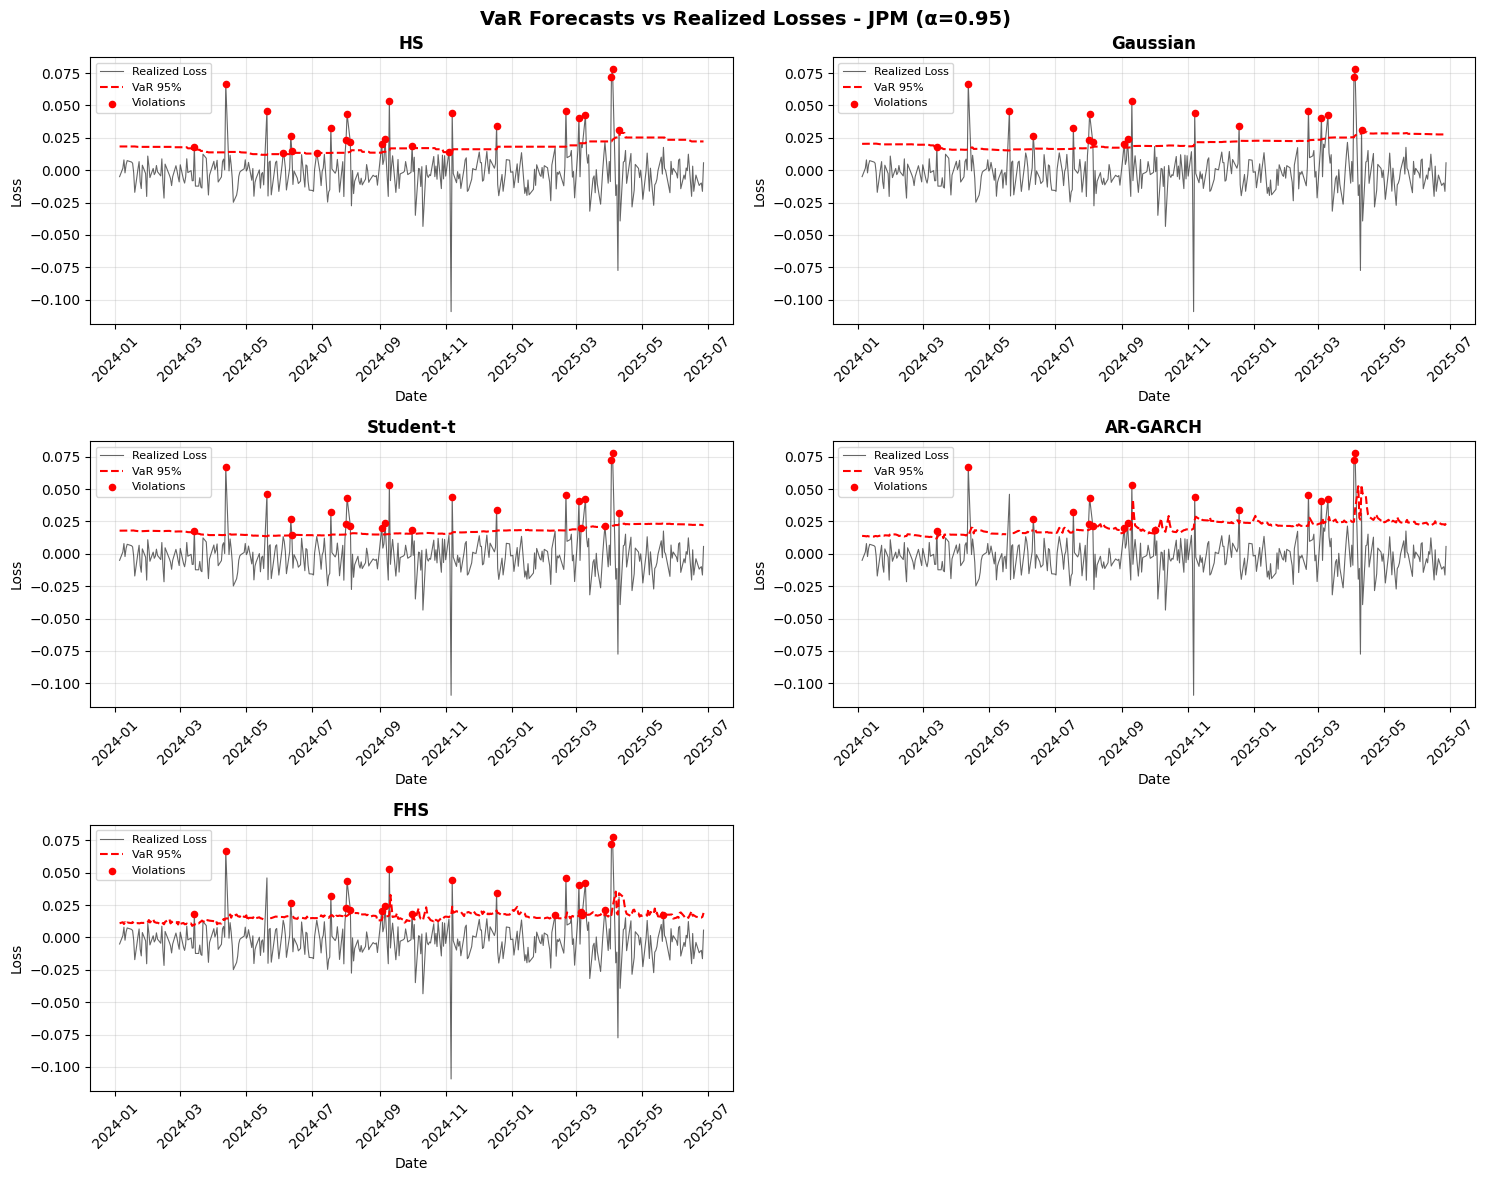


BACKTESTING SUMMARY TABLE
Ticker    Method  Alpha Violations POF_pval POF_Result CC_pval CC_Result     Z1 Z1_pval
  AAPL        HS   0.95 34 (0.092)    0.001     REJECT   0.000    REJECT  0.044   0.266
  AAPL        HS   0.99  7 (0.019)    0.125       PASS   0.087      PASS    NaN     NaN
  AAPL  Gaussian   0.95 31 (0.084)    0.006     REJECT   0.008    REJECT  0.191   0.002
  AAPL  Gaussian   0.99  9 (0.024)    0.019     REJECT   0.029    REJECT    NaN     NaN
  AAPL Student-t   0.95 40 (0.108)    0.000     REJECT   0.000    REJECT -0.015   0.546
  AAPL Student-t   0.99  7 (0.019)    0.125       PASS   0.087      PASS    NaN     NaN
  AAPL  AR-GARCH   0.95 30 (0.081)    0.012     REJECT   0.039    REJECT  0.229   0.000
  AAPL  AR-GARCH   0.99 13 (0.035)    0.000     REJECT   0.001    REJECT    NaN     NaN
  AAPL       FHS   0.95 35 (0.095)    0.000     REJECT   0.002    REJECT  0.121   0.062
  AAPL       FHS   0.99  5 (0.014)    0.519       PASS   0.116      PASS    NaN     NaN
  MET

In [ ]:
ar_orders = {'AAPL': 0, 'META': 0, 'JPM': 0}  # Adjust based on your ACF analysis

all_backtest_results = {}

for ticker in ['AAPL', 'META', 'JPM']:
    results, forecasts, losses, dates = backtest_asset(
        log_returns, ticker, W=252, alpha_primary=0.95, ar_order=ar_orders[ticker]
    )
    all_backtest_results[ticker] = results

# Create summary table
summary_rows = []
for ticker in ['AAPL', 'META', 'JPM']:
    for method in ['HS', 'Gaussian', 'Student-t', 'AR-GARCH', 'FHS']:
        for alpha in [0.95, 0.99]:
            if alpha in all_backtest_results[ticker][method]:
                res = all_backtest_results[ticker][method][alpha]
                row = {
                    'Ticker': ticker,
                    'Method': method,
                    'Alpha': alpha,
                    'Violations': f"{res['N']} ({res['p_hat']:.3f})",
                    'POF_pval': f"{res['p_pof']:.3f}",
                    'POF_Result': 'PASS' if res['p_pof'] >= 0.05 else 'REJECT',
                    'CC_pval': f"{res['p_cc']:.3f}",
                    'CC_Result': 'PASS' if res['p_cc'] >= 0.05 else 'REJECT'
                }
                if 'Z1' in res and alpha == 0.95:
                    row['Z1'] = f"{res['Z1']:.3f}" if not np.isnan(res['Z1']) else 'N/A'
                    row['Z1_pval'] = f"{res['p_z1']:.3f}" if not np.isnan(res['p_z1']) else 'N/A'
                summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print("\n" + "="*100)
print("BACKTESTING SUMMARY TABLE")
print("="*100)
print(summary_df.to_string(index=False))

## 4) Copula fitting (first window)

1. Visualize dependence in returns and copula space using pseudo-observations.
2. Fit Gaussian and t copulas; report parameters.
3. Simulate from fitted copulas and map to empirical marginals; compare with original returns.

In [ ]:
def compute_pseudo_observations(returns_df, W=252):
    """
    Compute empirical quantiles (pseudo-observations) for each asset

    U_{t,i} = rank(R_{t,i}) / (W+1), t = 1,...,W
    """
    tickers = returns_df.columns.tolist()
    window_data = returns_df.iloc[:W].copy()

    pseudo_obs = pd.DataFrame(index=window_data.index, columns=tickers)

    for ticker in tickers:
        # Compute ranks (using average method for ties)
        ranks = window_data[ticker].rank(method='average')
        # Convert to pseudo-observations
        pseudo_obs[ticker] = ranks / (W + 1)

    return pseudo_obs

def plot_dependence_structure(returns_df, W=252):
    """
    Plot scatter plots for both returns and pseudo-observations
    """
    tickers = returns_df.columns.tolist()
    window_returns = returns_df.iloc[:W]
    pseudo_obs = compute_pseudo_observations(returns_df, W)

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    pairs = [('AAPL', 'META'), ('AAPL', 'JPM'), ('META', 'JPM')]

    for idx, (asset_i, asset_j) in enumerate(pairs):
        # Top row: Returns space
        ax_returns = axes[0, idx]
        ax_returns.scatter(window_returns[asset_i], window_returns[asset_j],
                          alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
        ax_returns.set_xlabel(f'{asset_i} Returns', fontsize=11)
        ax_returns.set_ylabel(f'{asset_j} Returns', fontsize=11)
        ax_returns.set_title(f'Returns: {asset_i} vs {asset_j}',
                            fontsize=12, fontweight='bold')
        ax_returns.grid(True, alpha=0.3)

        # Compute correlation
        corr_returns = window_returns[asset_i].corr(window_returns[asset_j])
        ax_returns.text(0.05, 0.95, f'ρ = {corr_returns:.3f}',
                       transform=ax_returns.transAxes,
                       verticalalignment='top', fontsize=10,
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Bottom row: Pseudo-observations space
        ax_pseudo = axes[1, idx]
        ax_pseudo.scatter(pseudo_obs[asset_i], pseudo_obs[asset_j],
                         alpha=0.5, s=20, edgecolors='black', linewidth=0.5,
                         color='orange')
        ax_pseudo.set_xlabel(f'{asset_i} Pseudo-obs', fontsize=11)
        ax_pseudo.set_ylabel(f'{asset_j} Pseudo-obs', fontsize=11)
        ax_pseudo.set_title(f'Pseudo-observations: {asset_i} vs {asset_j}',
                           fontsize=12, fontweight='bold')
        ax_pseudo.grid(True, alpha=0.3)
        ax_pseudo.set_xlim([0, 1])
        ax_pseudo.set_ylim([0, 1])

        # Add reference lines for independence
        ax_pseudo.axhline(0.5, color='gray', linestyle='--', alpha=0.3)
        ax_pseudo.axvline(0.5, color='gray', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print analysis
    print("\n" + "="*80)
    print("DEPENDENCE STRUCTURE ANALYSIS")
    print("="*80)

    for asset_i, asset_j in pairs:
        print(f"\n{asset_i} vs {asset_j}:")
        corr = window_returns[asset_i].corr(window_returns[asset_j])
        print(f"  Pearson correlation: {corr:.4f}")

        # Kendall's tau for tail dependence
        tau, _ = stats.kendalltau(window_returns[asset_i], window_returns[asset_j])
        print(f"  Kendall's tau: {tau:.4f}")

        # Spearman's rho
        spearman, _ = stats.spearmanr(window_returns[asset_i], window_returns[asset_j])
        print(f"  Spearman's rho: {spearman:.4f}")

        # Check tail dependence
        lower_tail = ((window_returns[asset_i] < window_returns[asset_i].quantile(0.05)) &
                     (window_returns[asset_j] < window_returns[asset_j].quantile(0.05))).sum()
        upper_tail = ((window_returns[asset_i] > window_returns[asset_i].quantile(0.95)) &
                     (window_returns[asset_j] > window_returns[asset_j].quantile(0.95))).sum()

        print(f"  Lower tail co-movements (5%): {lower_tail}")
        print(f"  Upper tail co-movements (95%): {upper_tail}")
        print(f"  Tail symmetry: {'Symmetric' if abs(lower_tail - upper_tail) <= 2 else 'Asymmetric'}")

    print("\n" + "="*80)
    print("COPULA CHOICE MOTIVATION:")
    print("="*80)
    print("- Gaussian copula: Suitable if tail dependence is symmetric and weak")
    print("- Student-t copula: Better for symmetric but STRONG tail dependence")
    print("- Student-t allows for joint extreme events (fat tails in dependence)")
    print("="*80 + "\n")

def fit_gaussian_copula_manual(pseudo_obs):
    """
    Fit Gaussian copula using Canonical Maximum Likelihood (CML)

    For Gaussian copula, the correlation matrix is estimated by:
    R = corr(Z) where Z_i = Φ^{-1}(U_i)
    """
    print("\n" + "="*80)
    print("FITTING GAUSSIAN COPULA")
    print("="*80)

    # Transform pseudo-observations to standard normal
    U_clipped = np.clip(pseudo_obs.values, 1e-6, 1 - 1e-6)
    Z = stats.norm.ppf(U_clipped)

    # Estimate correlation matrix
    R = np.corrcoef(Z.T)

    print("\nGaussian Copula Parameters:")
    print("\nCorrelation Matrix R:")
    print(pd.DataFrame(R, index=pseudo_obs.columns, columns=pseudo_obs.columns))

    # Extract pairwise correlations
    tickers = pseudo_obs.columns.tolist()
    print("\nPairwise Correlations:")
    for i in range(len(tickers)):
        for j in range(i+1, len(tickers)):
            print(f"  ρ({tickers[i]}, {tickers[j]}) = {R[i,j]:.4f}")

    return R

def fit_student_t_copula_manual(pseudo_obs):
    """
    Fit Student-t copula using numerical optimization

    Parameters: nu (degrees of freedom) and correlation matrix R
    """
    print("\n" + "="*80)
    print("FITTING STUDENT-T COPULA")
    print("="*80)

    U = pseudo_obs.values
    N, d = U.shape

    def neg_log_likelihood(params):
        """Negative log-likelihood for Student-t copula"""
        nu = params[0]

        # Ensure nu > 2
        if nu <= 2 or nu > 100:
            return 1e10

        # Correlation parameters
        if d == 3:
            rho_12, rho_13, rho_23 = params[1], params[2], params[3]
            rho_12 = np.clip(rho_12, -0.95, 0.95)
            rho_13 = np.clip(rho_13, -0.95, 0.95)
            rho_23 = np.clip(rho_23, -0.95, 0.95)
            R = np.array([[1, rho_12, rho_13],
                          [rho_12, 1, rho_23],
                          [rho_13, rho_23, 1]])

        # Check positive definiteness
        eigvals = np.linalg.eigvalsh(R)
        if np.any(eigvals <= 0):
            return 1e10

        # Transform to Student-t quantiles
        U_clipped = np.clip(U, 1e-6, 1 - 1e-6)
        try:
            T_quantiles = stats.t.ppf(U_clipped, nu)
        except:
            return 1e10

        # Check for invalid values
        if np.any(~np.isfinite(T_quantiles)):
            return 1e10

        # Compute log-likelihood
        try:
            log_det_R = np.linalg.slogdet(R)[1]
            R_inv = np.linalg.inv(R)

            log_lik = 0
            for i in range(N):
                t = T_quantiles[i, :]

                # Multivariate t copula density components
                Q_R = t @ R_inv @ t
                Q_I = np.sum(t**2)

                # Log copula density
                log_c = (np.log(stats.gamma((nu + d) / 2))
                        - np.log(stats.gamma(nu / 2))
                        + 0.5 * log_det_R
                        + (nu / 2) * np.log(nu)
                        - ((nu + d) / 2) * np.log(nu + Q_R)
                        + np.sum(((nu + 1) / 2) * np.log(nu + t**2)))

                log_lik += log_c

            return -log_lik
        except:
            return 1e10

    # Initial guess: nu=5, correlations from Gaussian copula
    U_clipped = np.clip(U, 1e-6, 1 - 1e-6)
    Z = stats.norm.ppf(U_clipped)
    R_init = np.corrcoef(Z.T)

    if d == 3:
        initial_params = [5.0, R_init[0,1], R_init[0,2], R_init[1,2]]
        bounds = [(2.1, 50)] + [(-0.95, 0.95)] * 3

    print("\nOptimizing Student-t copula parameters...")
    result = minimize(neg_log_likelihood, initial_params,
                     method='L-BFGS-B', bounds=bounds,
                     options={'maxiter': 1000})

    if result.success:
        nu_opt = result.x[0]
        if d == 3:
            rho_12, rho_13, rho_23 = result.x[1], result.x[2], result.x[3]
            R_opt = np.array([[1, rho_12, rho_13],
                             [rho_12, 1, rho_23],
                             [rho_13, rho_23, 1]])

        print("\nStudent-t Copula Parameters:")
        print(f"\nDegrees of freedom (ν): {nu_opt:.4f}")
        print("\nCorrelation Matrix R:")
        print(pd.DataFrame(R_opt, index=pseudo_obs.columns, columns=pseudo_obs.columns))

        tickers = pseudo_obs.columns.tolist()
        print("\nPairwise Correlations:")
        for i in range(len(tickers)):
            for j in range(i+1, len(tickers)):
                print(f"  ρ({tickers[i]}, {tickers[j]}) = {R_opt[i,j]:.4f}")

        print(f"\nLog-likelihood: {-result.fun:.2f}")

        return nu_opt, R_opt
    else:
        print("Optimization failed!")
        return None, None

def simulate_from_gaussian_copula(R, n_samples):
    """
    Simulate from Gaussian copula

    1. Generate Z ~ N(0, R)
    2. Transform U = Φ(Z)
    """
    d = R.shape[0]

    # Generate multivariate normal samples
    Z = np.random.multivariate_normal(np.zeros(d), R, size=n_samples)

    # Transform to uniform
    U = stats.norm.cdf(Z)

    return U

def simulate_from_student_t_copula(nu, R, n_samples):
    """
    Simulate from Student-t copula

    1. Generate Z ~ MVT(0, R, nu)
    2. Transform U = t_nu(Z)
    """
    d = R.shape[0]

    # Generate from multivariate t-distribution
    # Method: Z = sqrt(nu/S) * X where X ~ N(0,R), S ~ chi2(nu)
    X = np.random.multivariate_normal(np.zeros(d), R, size=n_samples)
    S = np.random.chisquare(nu, size=n_samples)
    Z = X * np.sqrt(nu / S)[:, np.newaxis]

    # Transform to uniform using t CDF
    U = stats.t.cdf(Z, nu)

    return U

def transform_to_returns(U, empirical_cdfs):
    """
    Transform uniform samples to returns using inverse empirical CDF

    Parameters:
    - U: uniform samples (n_samples x d)
    - empirical_cdfs: dict with keys as tickers, values as sorted return series
    """
    n_samples, d = U.shape
    tickers = list(empirical_cdfs.keys())

    simulated_returns = pd.DataFrame(columns=tickers)

    for i, ticker in enumerate(tickers):
        sorted_returns = np.sort(empirical_cdfs[ticker].values)
        n = len(sorted_returns)

        # For each uniform sample, find corresponding return via inverse empirical CDF
        simulated_col = []
        for u in U[:, i]:
            # Find position in empirical CDF
            idx = int(np.floor(u * n))
            idx = min(idx, n - 1)  # Ensure within bounds
            simulated_col.append(sorted_returns[idx])

        simulated_returns[ticker] = simulated_col

    return simulated_returns

def copula_simulation_analysis(returns_df, R_gaussian, nu_t, R_t, W=252):
    """
    Complete copula simulation and comparison
    """
    print("\n" + "="*80)
    print("COPULA SIMULATION")
    print("="*80)

    tickers = returns_df.columns.tolist()
    window_returns = returns_df.iloc[:W]
    T = len(window_returns)

    # Store empirical CDFs
    empirical_cdfs = {ticker: window_returns[ticker] for ticker in tickers}

    # Simulate from both copulas
    print(f"\nSimulating {T} samples from Gaussian copula...")
    U_gaussian = simulate_from_gaussian_copula(R_gaussian, T)
    sim_returns_gaussian = transform_to_returns(U_gaussian, empirical_cdfs)

    print(f"Simulating {T} samples from Student-t copula...")
    U_t = simulate_from_student_t_copula(nu_t, R_t, T)
    sim_returns_t = transform_to_returns(U_t, empirical_cdfs)

    # Visual comparison
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))

    pairs = [('AAPL', 'META'), ('AAPL', 'JPM'), ('META', 'JPM')]

    for idx, (asset_i, asset_j) in enumerate(pairs):
        # Original data
        ax = axes[idx, 0]
        ax.scatter(window_returns[asset_i], window_returns[asset_j],
                  alpha=0.5, s=15, color='blue', label='Original')
        ax.set_title(f'Original: {asset_i} vs {asset_j}', fontweight='bold')
        ax.set_xlabel(f'{asset_i}')
        ax.set_ylabel(f'{asset_j}')
        ax.grid(True, alpha=0.3)
        ax.legend()

        # Gaussian copula simulation
        ax = axes[idx, 1]
        ax.scatter(sim_returns_gaussian[asset_i], sim_returns_gaussian[asset_j],
                  alpha=0.5, s=15, color='green', label='Gaussian Copula')
        ax.set_title(f'Gaussian Copula: {asset_i} vs {asset_j}', fontweight='bold')
        ax.set_xlabel(f'{asset_i}')
        ax.set_ylabel(f'{asset_j}')
        ax.grid(True, alpha=0.3)
        ax.legend()

        # Student-t copula simulation
        ax = axes[idx, 2]
        ax.scatter(sim_returns_t[asset_i], sim_returns_t[asset_j],
                  alpha=0.5, s=15, color='red', label='Student-t Copula')
        ax.set_title(f'Student-t Copula: {asset_i} vs {asset_j}', fontweight='bold')
        ax.set_xlabel(f'{asset_i}')
        ax.set_ylabel(f'{asset_j}')
        ax.grid(True, alpha=0.3)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Compare statistics
    print("\n" + "="*80)
    print("COMPARISON OF ORIGINAL AND SIMULATED DATA")
    print("="*80)

    for ticker in tickers:
        print(f"\n{ticker}:")
        print(f"  Original - Mean: {window_returns[ticker].mean():.6f}, "
              f"Std: {window_returns[ticker].std():.6f}")
        print(f"  Gaussian - Mean: {sim_returns_gaussian[ticker].mean():.6f}, "
              f"Std: {sim_returns_gaussian[ticker].std():.6f}")
        print(f"  Student-t - Mean: {sim_returns_t[ticker].mean():.6f}, "
              f"Std: {sim_returns_t[ticker].std():.6f}")

    print("\nPairwise Correlations:")
    for asset_i, asset_j in pairs:
        corr_orig = window_returns[asset_i].corr(window_returns[asset_j])
        corr_gauss = sim_returns_gaussian[asset_i].corr(sim_returns_gaussian[asset_j])
        corr_t = sim_returns_t[asset_i].corr(sim_returns_t[asset_j])

        print(f"\n{asset_i} vs {asset_j}:")
        print(f"  Original: {corr_orig:.4f}")
        print(f"  Gaussian: {corr_gauss:.4f}")
        print(f"  Student-t: {corr_t:.4f}")

    print("\n" + "="*80)
    print("OBSERVATIONS:")
    print("="*80)
    print("- Both copulas preserve marginal distributions (by construction)")
    print("- Gaussian copula may underestimate extreme co-movements")
    print("- Student-t copula better captures joint tail events")
    print("- Lower ν → stronger tail dependence in Student-t copula")
    print("="*80 + "\n")

    return sim_returns_gaussian, sim_returns_t

def run_copula_analysis(returns_df, W=252):
    """
    Run complete copula analysis
    """
    print("\n" + "#"*80)
    print("# PART 4: COPULA FITTING")
    print("#"*80)

    # 4.a) Pseudo-observations and dependence visualization
    print("\n--- Part 4.a): Pseudo-observations and dependence structure ---")
    plot_dependence_structure(returns_df, W)

    # Compute pseudo-observations
    pseudo_obs = compute_pseudo_observations(returns_df, W)

    # 4.b) Fit copulas
    print("\n--- Part 4.b): Copula fitting ---")
    R_gaussian = fit_gaussian_copula_manual(pseudo_obs)
    nu_t, R_t = fit_student_t_copula_manual(pseudo_obs)

    # 4.c) Simulation
    if nu_t is not None:
        print("\n--- Part 4.c): Copula simulation ---")
        sim_gaussian, sim_t = copula_simulation_analysis(
            returns_df, R_gaussian, nu_t, R_t, W
        )
        return R_gaussian, nu_t, R_t, sim_gaussian, sim_t
    else:
        return R_gaussian, None, None, None, None




################################################################################
# PART 4: COPULA FITTING
################################################################################

--- Part 4.a): Pseudo-observations and dependence structure ---


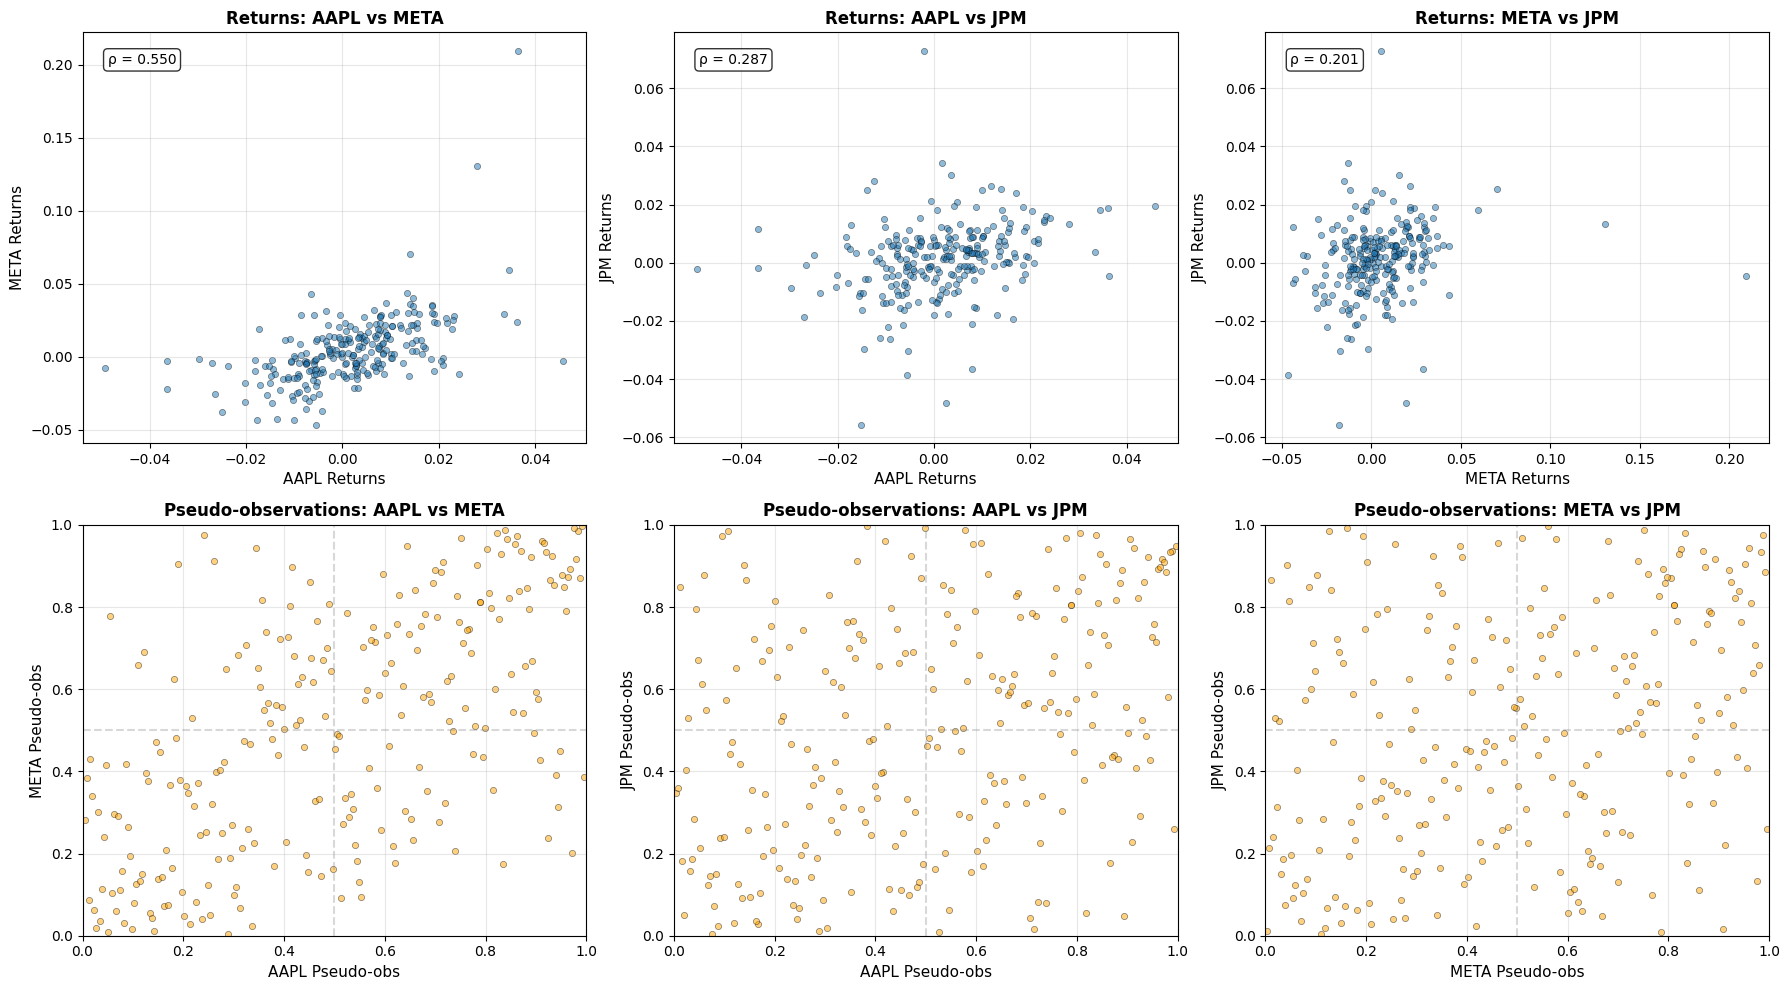


DEPENDENCE STRUCTURE ANALYSIS

AAPL vs META:
  Pearson correlation: 0.5502
  Kendall's tau: 0.4228
  Spearman's rho: 0.5961
  Lower tail co-movements (5%): 3
  Upper tail co-movements (95%): 3
  Tail symmetry: Symmetric

AAPL vs JPM:
  Pearson correlation: 0.2871
  Kendall's tau: 0.2432
  Spearman's rho: 0.3525
  Lower tail co-movements (5%): 1
  Upper tail co-movements (95%): 1
  Tail symmetry: Symmetric

META vs JPM:
  Pearson correlation: 0.2014
  Kendall's tau: 0.1984
  Spearman's rho: 0.2829
  Lower tail co-movements (5%): 1
  Upper tail co-movements (95%): 1
  Tail symmetry: Symmetric

COPULA CHOICE MOTIVATION:
- Gaussian copula: Suitable if tail dependence is symmetric and weak
- Student-t copula: Better for symmetric but STRONG tail dependence
- Student-t allows for joint extreme events (fat tails in dependence)


--- Part 4.b): Copula fitting ---

FITTING GAUSSIAN COPULA

Gaussian Copula Parameters:

Correlation Matrix R:
          META       JPM      AAPL
META  1.000000  0.2

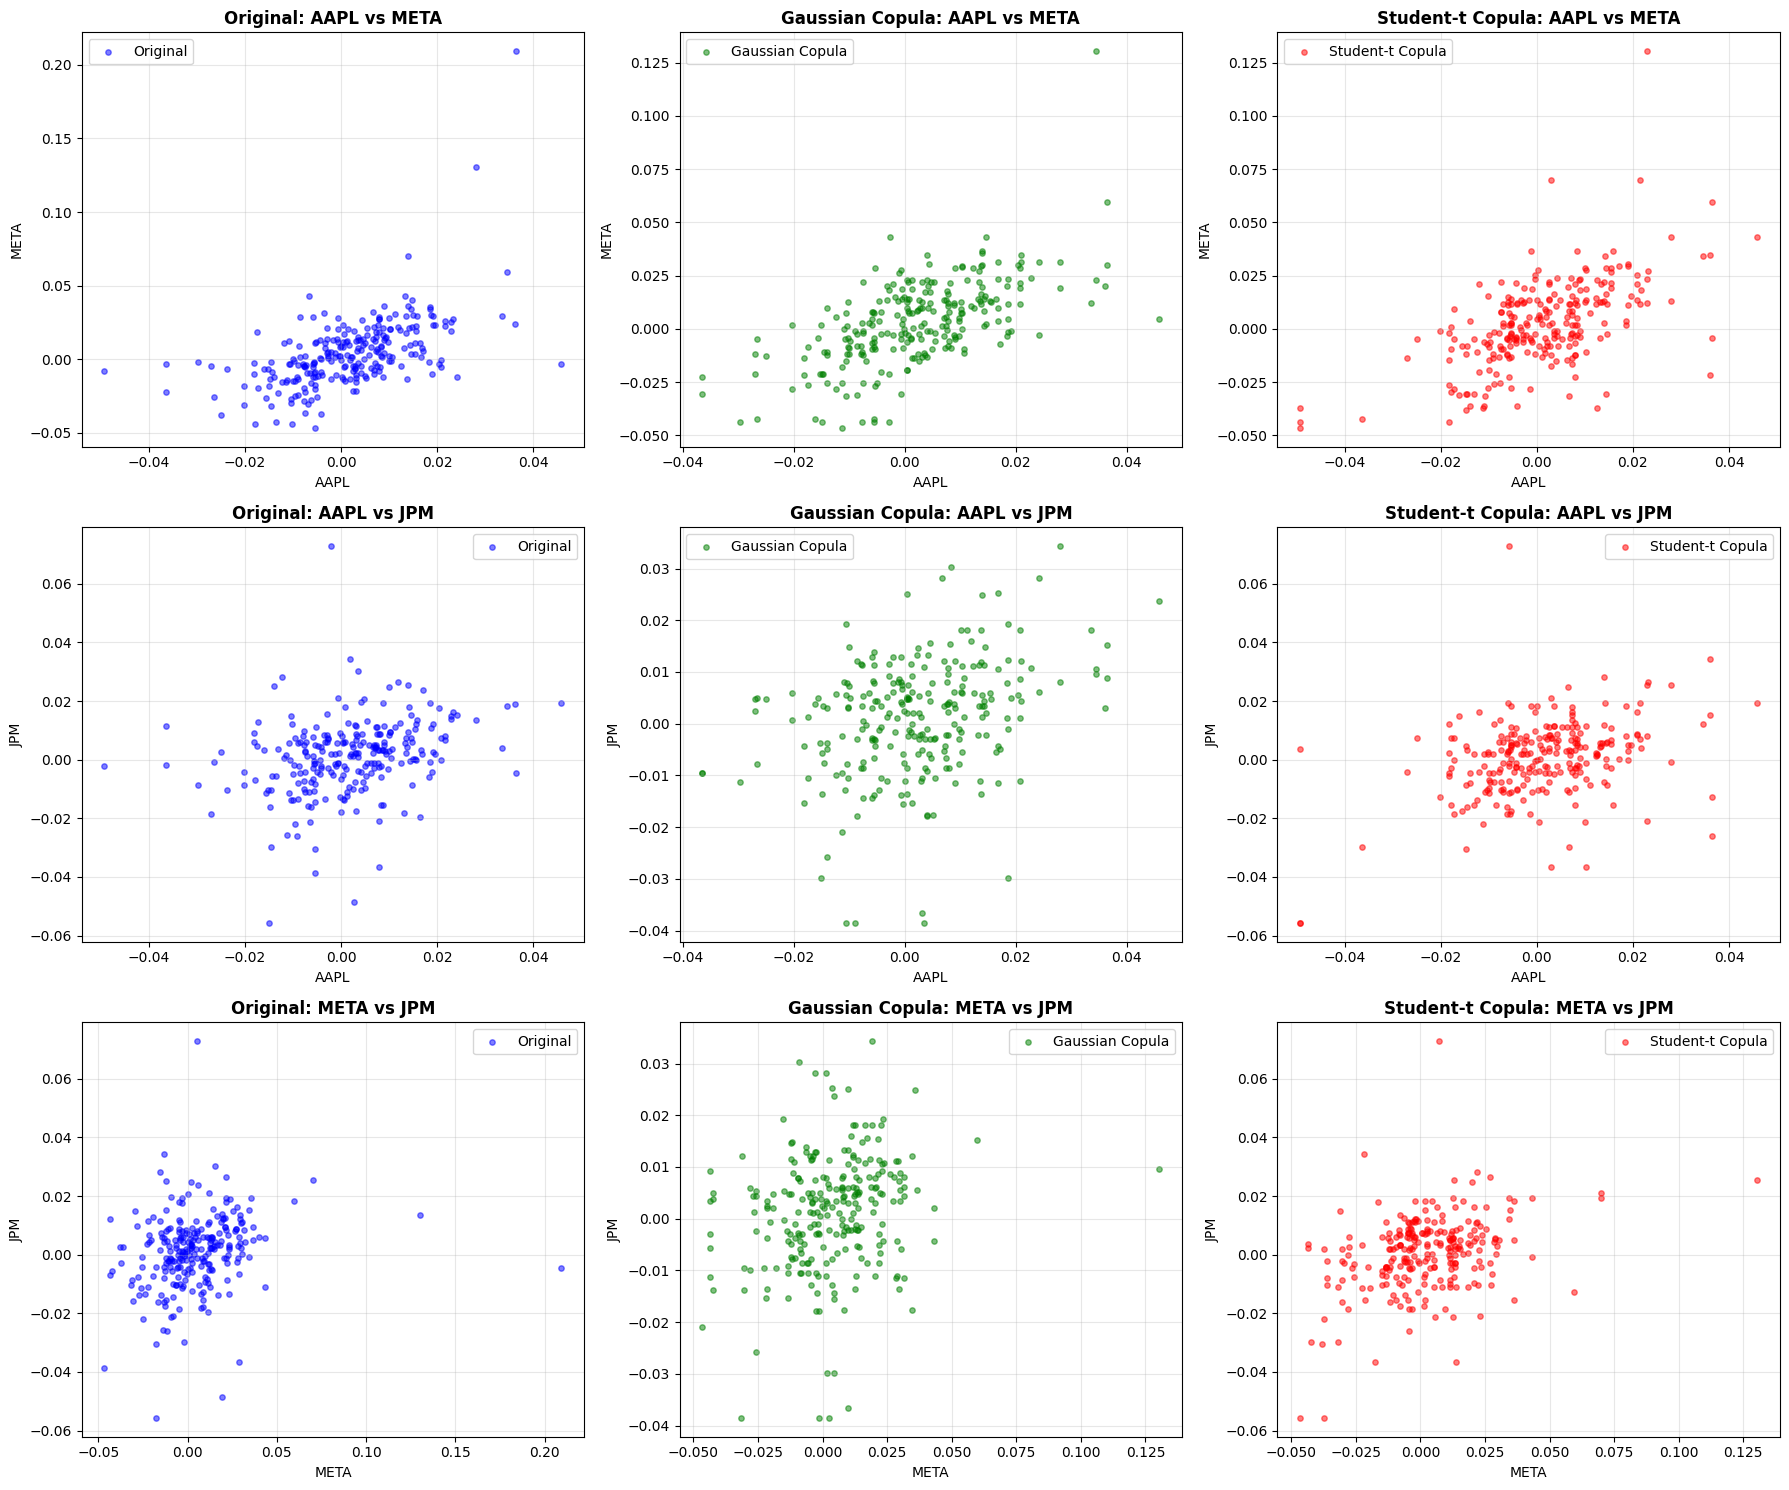


COMPARISON OF ORIGINAL AND SIMULATED DATA

META:
  Original - Mean: 0.004114, Std: 0.023959
  Gaussian - Mean: 0.003148, Std: 0.019989
  Student-t - Mean: 0.002175, Std: 0.020718

JPM:
  Original - Mean: 0.001096, Std: 0.013028
  Gaussian - Mean: 0.001155, Std: 0.011334
  Student-t - Mean: 0.000615, Std: 0.013081

AAPL:
  Original - Mean: 0.001600, Std: 0.012729
  Gaussian - Mean: 0.002177, Std: 0.012926
  Student-t - Mean: 0.001146, Std: 0.013304

Pairwise Correlations:

AAPL vs META:
  Original: 0.5502
  Gaussian: 0.6136
  Student-t: 0.5854

AAPL vs JPM:
  Original: 0.2871
  Gaussian: 0.3291
  Student-t: 0.3547

META vs JPM:
  Original: 0.2014
  Gaussian: 0.2225
  Student-t: 0.3595

OBSERVATIONS:
- Both copulas preserve marginal distributions (by construction)
- Gaussian copula may underestimate extreme co-movements
- Student-t copula better captures joint tail events
- Lower ν → stronger tail dependence in Student-t copula



In [ ]:

results = run_copula_analysis(log_returns, W=252)
R_gaussian, nu_t, R_t, sim_gaussian, sim_t = results


## 5) Portfolio VaR/ES with copulas (rolling)

Equal-weighted portfolio of AAPL, MSFT, JPM. Compare univariate models (as in Exercise 3) vs copula-based VaR/ES with rolling windows.

At each time, fit copulas on last W weeks, simulate N scenarios, estimate VaR/ES from simulated portfolio returns, then backtest.

In [ ]:

def construct_equal_weighted_portfolio(returns_df):
    """
    Construct equal-weighted portfolio returns

    R_p,t = (1/3) * (R_AAPL,t + R_META,t + R_JPM,t)
    """
    portfolio_returns = returns_df.mean(axis=1)
    return portfolio_returns

def backtest_portfolio_univariate(portfolio_returns, W=252, alpha_levels=[0.95, 0.99], ar_order=0):
    """
    Backtest portfolio VaR/ES using univariate methods on portfolio returns
    Same methods as Question 2, but on portfolio level
    """
    T = len(portfolio_returns)

    # Initialize storage
    forecasts = {
        'HS': {alpha: {'VaR': [], 'ES': []} for alpha in alpha_levels},
        'Gaussian': {alpha: {'VaR': [], 'ES': []} for alpha in alpha_levels},
        'Student-t': {alpha: {'VaR': [], 'ES': []} for alpha in alpha_levels},
        'AR-GARCH': {alpha: {'VaR': [], 'ES': []} for alpha in alpha_levels},
        'FHS': {alpha: {'VaR': [], 'ES': []} for alpha in alpha_levels}
    }

    realized_losses = []
    forecast_dates = []

    print(f"\n{'='*80}")
    print("UNIVARIATE PORTFOLIO BACKTESTING")
    print(f"{'='*80}")
    print(f"Rolling window forecasting on portfolio returns...")

    # Rolling window loop
    for t in range(W, T):
        window_returns = portfolio_returns.iloc[t-W+1:t+1]
        window_losses = -window_returns

        if t + 1 < T:
            realized_loss = -portfolio_returns.iloc[t+1]
            realized_losses.append(realized_loss)
            forecast_dates.append(portfolio_returns.index[t+1])
        else:
            break

        # Historical Simulation
        for alpha in alpha_levels:
            var_hs = np.quantile(window_losses, alpha)
            es_hs = window_losses[window_losses >= var_hs].mean()
            forecasts['HS'][alpha]['VaR'].append(var_hs)
            forecasts['HS'][alpha]['ES'].append(es_hs)

        # Gaussian
        mu = window_losses.mean()
        sigma = window_losses.std(ddof=1)
        for alpha in alpha_levels:
            z_alpha = stats.norm.ppf(alpha)
            var_g = mu + sigma * z_alpha
            es_g = mu + sigma * stats.norm.pdf(z_alpha) / (1 - alpha)
            forecasts['Gaussian'][alpha]['VaR'].append(var_g)
            forecasts['Gaussian'][alpha]['ES'].append(es_g)

        # Student-t
        params = stats.t.fit(window_losses)
        nu, mu_t, sigma_t = params
        for alpha in alpha_levels:
            t_alpha = stats.t.ppf(alpha, nu)
            var_t = mu_t + sigma_t * t_alpha
            t_pdf = stats.t.pdf(t_alpha, nu)
            es_t = mu_t + sigma_t * t_pdf * (nu + t_alpha**2) / ((1 - alpha) * (nu - 1))
            forecasts['Student-t'][alpha]['VaR'].append(var_t)
            forecasts['Student-t'][alpha]['ES'].append(es_t)

        # AR-GARCH
        try:
            model = arch_model(-window_losses, vol='Garch', p=1, q=1,
                             mean='constant', lags=ar_order, dist='normal')
            fitted = model.fit(disp='off', show_warning=False)

            forecast = fitted.forecast(horizon=1)
            mu_forecast = forecast.mean.iloc[-1, 0]
            sigma_forecast = np.sqrt(forecast.variance.iloc[-1, 0])

            if fitted.convergence_flag != 0:
                print(mu_forecast, sigma_forecast, fitted.convergence_flag)
                mu_forecast = np.nan
                sigma_forecast = np.nan

            mu_loss = -mu_forecast

            for alpha in alpha_levels:
                z_alpha = stats.norm.ppf(alpha)
                var_cond = mu_loss + sigma_forecast * z_alpha
                es_cond = mu_loss + sigma_forecast * stats.norm.pdf(z_alpha) / (1 - alpha)
                forecasts['AR-GARCH'][alpha]['VaR'].append(var_cond)
                forecasts['AR-GARCH'][alpha]['ES'].append(es_cond)

            # FHS
            residuals = fitted.resid
            conditional_vol = fitted.conditional_volatility
            std_residuals = (residuals / conditional_vol).dropna()

            M = 1000
            np.random.seed(t)
            bootstrapped = np.random.choice(std_residuals, size=M, replace=True)
            loss_scenarios = mu_loss + sigma_forecast * bootstrapped

            for alpha in alpha_levels:
                var_fhs = np.quantile(loss_scenarios, alpha)
                es_fhs = loss_scenarios[loss_scenarios >= var_fhs].mean()
                forecasts['FHS'][alpha]['VaR'].append(var_fhs)
                forecasts['FHS'][alpha]['ES'].append(es_fhs)

        except:
            for alpha in alpha_levels:
                forecasts['AR-GARCH'][alpha]['VaR'].append(np.nan)
                forecasts['AR-GARCH'][alpha]['ES'].append(np.nan)
                forecasts['FHS'][alpha]['VaR'].append(np.nan)
                forecasts['FHS'][alpha]['ES'].append(np.nan)

    return forecasts, realized_losses, forecast_dates

def fit_copula_on_window(returns_window, copula_type='gaussian'):
    """
    Fit copula on a window of component returns
    """
    # Compute pseudo-observations
    W = len(returns_window)
    pseudo_obs = pd.DataFrame(index=returns_window.index, columns=returns_window.columns)

    for col in returns_window.columns:
        ranks = returns_window[col].rank(method='average')
        pseudo_obs[col] = ranks / (W + 1)

    U = pseudo_obs.values
    U_clipped = np.clip(U, 1e-6, 1 - 1e-6)

    if copula_type == 'gaussian':
        # Gaussian copula: R = corr(Φ^{-1}(U))
        Z = stats.norm.ppf(U_clipped)
        R = np.corrcoef(Z.T)
        return {'type': 'gaussian', 'R': R}

    elif copula_type == 'student-t':
        # Student-t copula: optimize nu and R
        d = U.shape[1]

        def neg_log_lik(params):
            nu = params[0]
            if nu <= 2 or nu > 50:
                return 1e10

            rho_12, rho_13, rho_23 = params[1], params[2], params[3]
            rho_12 = np.clip(rho_12, -0.95, 0.95)
            rho_13 = np.clip(rho_13, -0.95, 0.95)
            rho_23 = np.clip(rho_23, -0.95, 0.95)
            R = np.array([[1, rho_12, rho_13],
                          [rho_12, 1, rho_23],
                          [rho_13, rho_23, 1]])

            eigvals = np.linalg.eigvalsh(R)
            if np.any(eigvals <= 0):
                return 1e10

            try:
                T_q = stats.t.ppf(U_clipped, nu)
                if np.any(~np.isfinite(T_q)):
                    return 1e10

                log_det_R = np.linalg.slogdet(R)[1]
                R_inv = np.linalg.inv(R)

                log_lik = 0
                for i in range(len(U)):
                    t = T_q[i, :]
                    Q_R = t @ R_inv @ t

                    log_c = (np.log(stats.gamma((nu + d) / 2))
                            - np.log(stats.gamma(nu / 2))
                            + 0.5 * log_det_R
                            + (nu / 2) * np.log(nu)
                            - ((nu + d) / 2) * np.log(nu + Q_R)
                            + np.sum(((nu + 1) / 2) * np.log(nu + t**2)))

                    log_lik += log_c

                return -log_lik
            except:
                return 1e10

        # Initial guess
        Z = stats.norm.ppf(U_clipped)
        R_init = np.corrcoef(Z.T)
        initial = [5.0, R_init[0,1], R_init[0,2], R_init[1,2]]
        bounds = [(2.1, 50)] + [(-0.95, 0.95)] * 3

        from scipy.optimize import minimize
        result = minimize(neg_log_lik, initial, method='L-BFGS-B',
                         bounds=bounds, options={'maxiter': 500})

        if result.success:
            nu = result.x[0]
            rho_12, rho_13, rho_23 = result.x[1], result.x[2], result.x[3]
            R = np.array([[1, rho_12, rho_13],
                          [rho_12, 1, rho_23],
                          [rho_13, rho_23, 1]])
            return {'type': 'student-t', 'nu': nu, 'R': R}
        else:
            # Fall back to Gaussian
            Z = stats.norm.ppf(U_clipped)
            R = np.corrcoef(Z.T)
            return {'type': 'gaussian', 'R': R}

def simulate_copula_portfolio_returns(copula_params, component_returns_window, N=1000):
    """
    Simulate portfolio returns from fitted copula

    1. Simulate from copula -> get uniform samples
    2. Transform to component returns via inverse empirical CDF
    3. Compute portfolio returns (equal-weighted)
    """
    d = len(component_returns_window.columns)
    copula_type = copula_params['type']
    R = copula_params['R']

    # Simulate uniform samples from copula
    if copula_type == 'gaussian':
        Z = np.random.multivariate_normal(np.zeros(d), R, size=N)
        U = stats.norm.cdf(Z)

    elif copula_type == 'student-t':
        nu = copula_params['nu']
        X = np.random.multivariate_normal(np.zeros(d), R, size=N)
        S = np.random.chisquare(nu, size=N)
        Z = X * np.sqrt(nu / S)[:, np.newaxis]
        U = stats.t.cdf(Z, nu)

    # Transform to component returns via inverse empirical CDF
    simulated_components = np.zeros((N, d))

    for i, col in enumerate(component_returns_window.columns):
        sorted_returns = np.sort(component_returns_window[col].values)
        n = len(sorted_returns)

        for j in range(N):
            idx = int(np.floor(U[j, i] * n))
            idx = min(idx, n - 1)
            simulated_components[j, i] = sorted_returns[idx]

    # Compute equal-weighted portfolio returns
    portfolio_returns_sim = simulated_components.mean(axis=1)

    return portfolio_returns_sim

def backtest_portfolio_copula(returns_df, W=252, alpha_levels=[0.95, 0.99],
                               copula_type='gaussian', N=1000):
    """
    Backtest portfolio VaR/ES using copula-based approach
    """
    tickers = returns_df.columns.tolist()
    portfolio_returns = construct_equal_weighted_portfolio(returns_df)
    T = len(portfolio_returns)

    forecasts = {alpha: {'VaR': [], 'ES': []} for alpha in alpha_levels}
    realized_losses = []
    forecast_dates = []

    print(f"\n{'='*80}")
    print(f"COPULA-BASED PORTFOLIO BACKTESTING ({copula_type.upper()})")
    print(f"{'='*80}")
    print(f"Rolling window forecasting with N={N} simulations per window...")

    for t in range(W, T):
        # Get window of component returns
        window_returns = returns_df.iloc[t-W+1:t+1]

        if t + 1 < T:
            realized_loss = -portfolio_returns.iloc[t+1]
            realized_losses.append(realized_loss)
            forecast_dates.append(portfolio_returns.index[t+1])
        else:
            break

        # Fit copula on component returns
        try:
            copula_params = fit_copula_on_window(window_returns, copula_type)

            # Simulate portfolio returns
            sim_portfolio_returns = simulate_copula_portfolio_returns(
                copula_params, window_returns, N=N
            )

            # Convert to losses
            sim_portfolio_losses = -sim_portfolio_returns

            # Compute VaR and ES from simulated distribution
            for alpha in alpha_levels:
                var_cop = np.quantile(sim_portfolio_losses, alpha)
                es_cop = sim_portfolio_losses[sim_portfolio_losses >= var_cop].mean()
                forecasts[alpha]['VaR'].append(var_cop)
                forecasts[alpha]['ES'].append(es_cop)

        except Exception as e:
            for alpha in alpha_levels:
                forecasts[alpha]['VaR'].append(np.nan)
                forecasts[alpha]['ES'].append(np.nan)

        if (t - W) % 50 == 0:
            print(f"  Progress: {t-W}/{T-W} windows completed")

    return forecasts, realized_losses, forecast_dates

def compare_portfolio_backtests_with_z1(univariate_forecasts, copula_gaussian_forecasts,
                                copula_t_forecasts, realized_losses,
                                forecast_dates, alpha=0.95, M_z1=2000):
    """
    Compare backtesting results across all methods
    """
    print(f"\n{'='*80}")
    print(f"PORTFOLIO BACKTEST COMPARISON (α = {alpha})")
    print(f"{'='*80}\n")

    T_out = len(realized_losses)
    realized = np.array(realized_losses)

    # Prepare results table
    results = []

    # Univariate methods
    univariate_methods = ['HS', 'Gaussian', 'Student-t', 'AR-GARCH', 'FHS']

    for method in univariate_methods:
        var_fc = np.array(univariate_forecasts[method][alpha]['VaR'])
        es_fc = np.array(univariate_forecasts[method][alpha]['ES'])

        valid = ~np.isnan(var_fc)
        var_valid = var_fc[valid]
        es_valid = es_fc[valid]

        realized_valid = realized[valid]
        T_valid = len(realized_valid)

        if T_valid > 0:
            violations = (realized_valid > var_valid).astype(int)
            LR_POF, p_pof, N, p_hat = kupiec_pof_test(violations, T_valid, alpha)
            LR_ind, LR_cc, p_ind, p_cc = christoffersen_test(violations, T_valid, alpha)

            # === Acerbi-Székely Z1 Test ===
            Z1_obs, p_z1 = acerbi_szekely_z1_test(realized_valid, var_valid, es_valid, M=M_z1)

            if np.isnan(Z1_obs):
                z1_str = "N/A"
                p_z1_str = "N/A"
                z1_result = "INCONCLUSIVE"
            else:
                z1_str = f"{Z1_obs:+.3f}"
                p_z1_str = f"{p_z1:.3f}"
                z1_result = "REJECT (ES too low)" if p_z1 < (1-alpha) else "PASS"
                if Z1_obs > 0:
                    z1_str += " ↑"
                else:
                    z1_str += " ↓"

            results.append({
                'Approach': 'Univariate',
                'Method': method,
                'Violations': f"{N}/{T_valid}",
                'Rate': f"{p_hat:.4f}",
                'POF_pval': f"{p_pof:.3f}",
                'CC_pval': f"{p_cc:.3f}",
                'Avg_VaR': f"{np.mean(var_valid):.4f}",
                'Avg_ES': f"{np.mean(es_fc[valid]):.4f}",
                'Z1': z1_str,
                'Z1 p-val': p_z1_str,
                'Z1 Result': z1_result
            })

    # Copula-based methods
    for copula_name, copula_fc in [('Gaussian Copula', copula_gaussian_forecasts),
                                    ('Student-t Copula', copula_t_forecasts)]:
        if copula_fc is not None:
            var_fc = np.array(copula_fc[alpha]['VaR'])
            es_fc = np.array(copula_fc[alpha]['ES'])

            valid = ~np.isnan(var_fc)
            var_valid = var_fc[valid]
            es_valid = es_fc[valid]
            realized_valid = realized[valid]
            T_valid = len(realized_valid)

            if T_valid > 0:
                violations = (realized_valid > var_valid).astype(int)
                LR_POF, p_pof, N, p_hat = kupiec_pof_test(violations, T_valid, alpha)
                LR_ind, LR_cc, p_ind, p_cc = christoffersen_test(violations, T_valid, alpha)

                    # === Acerbi-Székely Z1 Test ===
                Z1_obs, p_z1 = acerbi_szekely_z1_test(realized_valid, var_valid, es_valid, M=M_z1)

                if np.isnan(Z1_obs):
                    z1_str = "N/A"
                    p_z1_str = "N/A"
                    z1_result = "INCONCLUSIVE"
                else:
                    z1_str = f"{Z1_obs:+.3f}"
                    p_z1_str = f"{p_z1:.3f}"
                    z1_result = "REJECT (ES too low)" if p_z1 < (1 - alpha) else "PASS"
                    if Z1_obs > 0:
                        z1_str += " ↑"
                    else:
                        z1_str += " ↓"

                results.append({
                    'Approach': 'Copula',
                    'Method': copula_name,
                    'Violations': f"{N}/{T_valid}",
                    'Rate': f"{p_hat:.4f}",
                    'POF_pval': f"{p_pof:.3f}",
                    'CC_pval': f"{p_cc:.3f}",
                    'Avg_VaR': f"{np.mean(var_valid):.4f}",
                    'Avg_ES': f"{np.mean(es_fc[valid]):.4f}",
                    'Z1': z1_str,
                    'Z1 p-val': p_z1_str,
                    'Z1 Result': z1_result
                })

    results_df = pd.DataFrame(results)
    print(results_df.to_string(index=False))

    # Visual comparison
    plot_portfolio_backtest_comparison(univariate_forecasts, copula_gaussian_forecasts,
                                      copula_t_forecasts, realized_losses,
                                      forecast_dates, alpha)

    # Analysis and discussion
    print(f"\n{'='*80}")
    print("ANALYSIS: DOES DEPENDENCE MODELING IMPROVE RESULTS?")
    print(f"{'='*80}\n")

    print("Key Observations:")
    print("\n1. COVERAGE ACCURACY:")
    print("   - Compare violation rates to nominal level (1-α)")
    print("   - Methods passing POF test have appropriate coverage")

    print("\n2. INDEPENDENCE (CC test):")
    print("   - Passing CC test → violations are independent (not clustered)")
    print("   - Failing → systematic underestimation during crisis periods")

    print("\n3. TAIL RISK ESTIMATION:")
    print("   - Compare Avg_VaR and Avg_ES across methods")
    print("   - Copula methods may capture tail co-movements better")

    print("\n4. DEPENDENCE MODELING BENEFITS:")
    print("   - Copulas explicitly model cross-asset dependence structure")
    print("   - Student-t copula captures tail dependence (joint extremes)")
    print("   - Univariate approaches ignore diversification breakdown in tails")

    print("\n5. POTENTIAL REASONS FOR IMPROVEMENT (or lack thereof):")
    print("   - If copula improves → cross-asset tail dependence is significant")
    print("   - If no improvement → portfolio diversification already captured")
    print("   - Equal-weighting may reduce sensitivity to dependence structure")
    print("   - Small portfolio (3 assets) limits copula benefits")

    print(f"\n{'='*80}\n")

    return results_df

def plot_portfolio_backtest_comparison(univ_fc, cop_gauss_fc, cop_t_fc,
                                       realized, dates, alpha=0.95):
    """
    Plot VaR forecasts comparison
    """
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    axes = axes.flatten()

    methods_univ = ['HS', 'Gaussian', 'Student-t', 'AR-GARCH', 'FHS']

    for idx, method in enumerate(methods_univ):
        ax = axes[idx]
        var_fc = univ_fc[method][alpha]['VaR']

        ax.plot(dates, realized, label='Realized Loss', alpha=0.6,
               linewidth=0.8, color='black')
        ax.plot(dates, var_fc, label=f'VaR {int(alpha*100)}%',
               color='red', linewidth=1.5, linestyle='--')

        violations = np.array(realized) > np.array(var_fc)
        viol_dates = np.array(dates)[violations]
        viol_losses = np.array(realized)[violations]
        ax.scatter(viol_dates, viol_losses, color='red', s=20, zorder=5)

        ax.set_title(f'Univariate: {method}', fontsize=11, fontweight='bold')
        ax.set_ylabel('Portfolio Loss')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

    # Copula methods
    if cop_gauss_fc is not None:
        ax = axes[5]
        var_gauss = cop_gauss_fc[alpha]['VaR']
        var_t = cop_t_fc[alpha]['VaR'] if cop_t_fc is not None else None

        ax.plot(dates, realized, label='Realized Loss', alpha=0.6,
               linewidth=0.8, color='black')
        ax.plot(dates, var_gauss, label='Gaussian Copula VaR',
               color='green', linewidth=1.5, linestyle='--')
        if var_t is not None:
            ax.plot(dates, var_t, label='Student-t Copula VaR',
                   color='purple', linewidth=1.5, linestyle=':')

        ax.set_title('Copula Methods', fontsize=11, fontweight='bold')
        ax.set_ylabel('Portfolio Loss')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

    plt.suptitle(f'Portfolio VaR Backtesting Comparison (α={alpha})',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def run_portfolio_backtesting(returns_df, W=252, ar_order=0, N_copula=1000, M_z1=2000):
    """
    Complete portfolio backtesting analysis
    """
    print("\n" + "#"*80)
    print("# PART 5: BACKTESTING PORTFOLIO VaR AND ES")
    print("#"*80)

    # Construct equal-weighted portfolio
    portfolio_returns = construct_equal_weighted_portfolio(returns_df)
    print(f"\nEqual-weighted portfolio constructed")
    print(f"Portfolio statistics:")
    print(f"  Mean: {portfolio_returns.mean():.6f}")
    print(f"  Std: {portfolio_returns.std():.6f}")
    print(f"  Sharpe (annualized, assuming Rf=0): {(portfolio_returns.mean()/portfolio_returns.std())*np.sqrt(252):.4f}")

    # 5.a) Univariate backtesting
    print(f"\n{'='*80}")
    print("Part 5.a): Univariate Portfolio Backtesting")
    print(f"{'='*80}")

    univ_forecasts, realized_losses, forecast_dates = backtest_portfolio_univariate(
        portfolio_returns, W=W, alpha_levels=[0.95, 0.99], ar_order=ar_order
    )

    # 5.b) Copula-based backtesting
    print(f"\n{'='*80}")
    print("Part 5.b): Copula-based Portfolio Backtesting")
    print(f"{'='*80}")

    cop_gauss_fc, _, _ = backtest_portfolio_copula(
        returns_df, W=W, alpha_levels=[0.95, 0.99],
        copula_type='gaussian', N=N_copula
    )

    cop_t_fc, _, _ = backtest_portfolio_copula(
        returns_df, W=W, alpha_levels=[0.95, 0.99],
        copula_type='student-t', N=N_copula
    )

    # 5.c) Comparison
    print(f"\n{'='*80}")
    print("Part 5.c): Comparison and Analysis")
    print(f"{'='*80}")

    for alpha in [0.95, 0.99]:
        print(f"\n\n{'#'*80}")
        print(f"# RESULTS FOR α = {alpha}")
        print(f"{'#'*80}")

        results_df = compare_portfolio_backtests_with_z1(
            univ_forecasts, cop_gauss_fc, cop_t_fc,
            realized_losses, forecast_dates, alpha=alpha, M_z1=M_z1
        )

    return univ_forecasts, cop_gauss_fc, cop_t_fc, realized_losses, forecast_dates




################################################################################
# PART 5: BACKTESTING PORTFOLIO VaR AND ES
################################################################################

Equal-weighted portfolio constructed
Portfolio statistics:
  Mean: 0.001671
  Std: 0.014180
  Sharpe (annualized, assuming Rf=0): 1.8708

Part 5.a): Univariate Portfolio Backtesting

UNIVARIATE PORTFOLIO BACKTESTING
Rolling window forecasting on portfolio returns...
0.23195961833961962 0.21513048688468253 4
0.0015076925431682679 0.011856599065974808 8
-0.39886353417933057 0.40033727597612245 4
0.01581131915259011 0.019803664181621394 4
0.0017178758171000608 0.012124568703883185 8
0.001137136184776165 0.010978483244251335 9

Part 5.b): Copula-based Portfolio Backtesting

COPULA-BASED PORTFOLIO BACKTESTING (GAUSSIAN)
Rolling window forecasting with N=1000 simulations per window...
  Progress: 0/371 windows completed
  Progress: 50/371 windows completed
  Progress: 100/371 windows comp

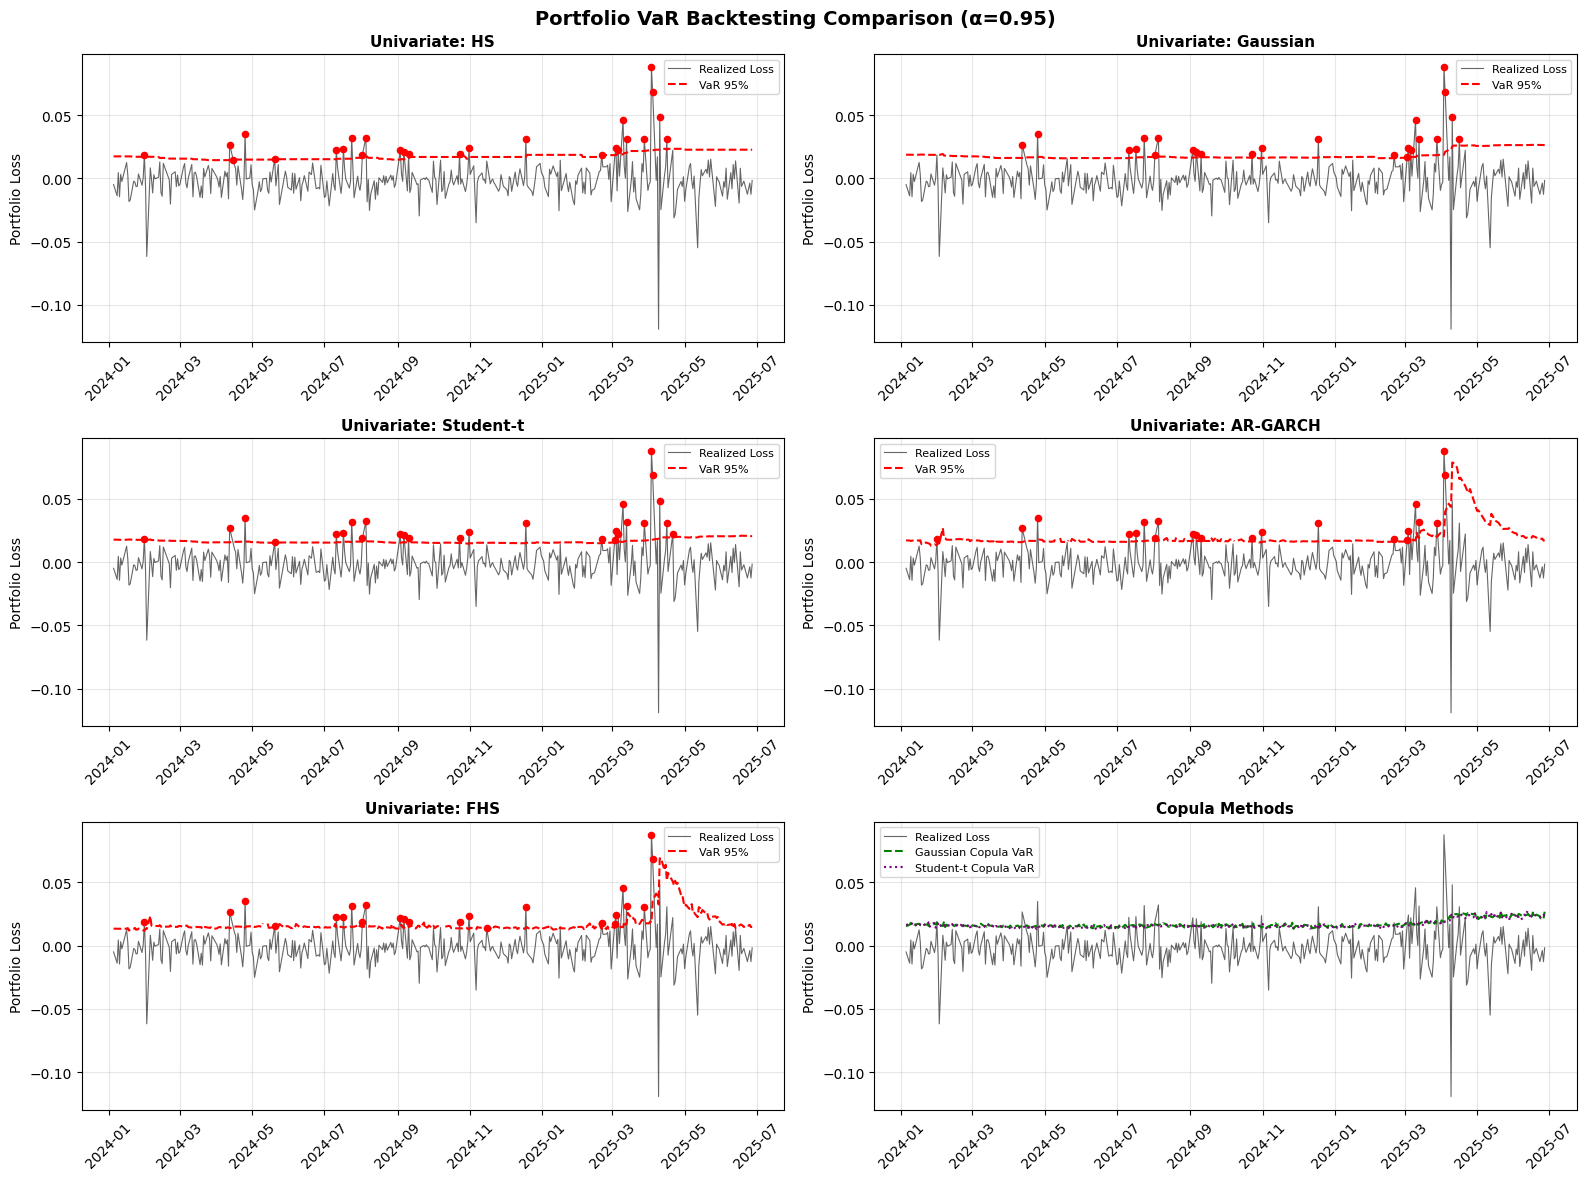


ANALYSIS: DOES DEPENDENCE MODELING IMPROVE RESULTS?

Key Observations:

1. COVERAGE ACCURACY:
   - Compare violation rates to nominal level (1-α)
   - Methods passing POF test have appropriate coverage

2. INDEPENDENCE (CC test):
   - Passing CC test → violations are independent (not clustered)
   - Failing → systematic underestimation during crisis periods

3. TAIL RISK ESTIMATION:
   - Compare Avg_VaR and Avg_ES across methods
   - Copula methods may capture tail co-movements better

4. DEPENDENCE MODELING BENEFITS:
   - Copulas explicitly model cross-asset dependence structure
   - Student-t copula captures tail dependence (joint extremes)
   - Univariate approaches ignore diversification breakdown in tails

5. POTENTIAL REASONS FOR IMPROVEMENT (or lack thereof):
   - If copula improves → cross-asset tail dependence is significant
   - If no improvement → portfolio diversification already captured
   - Equal-weighting may reduce sensitivity to dependence structure
   - Small portfo

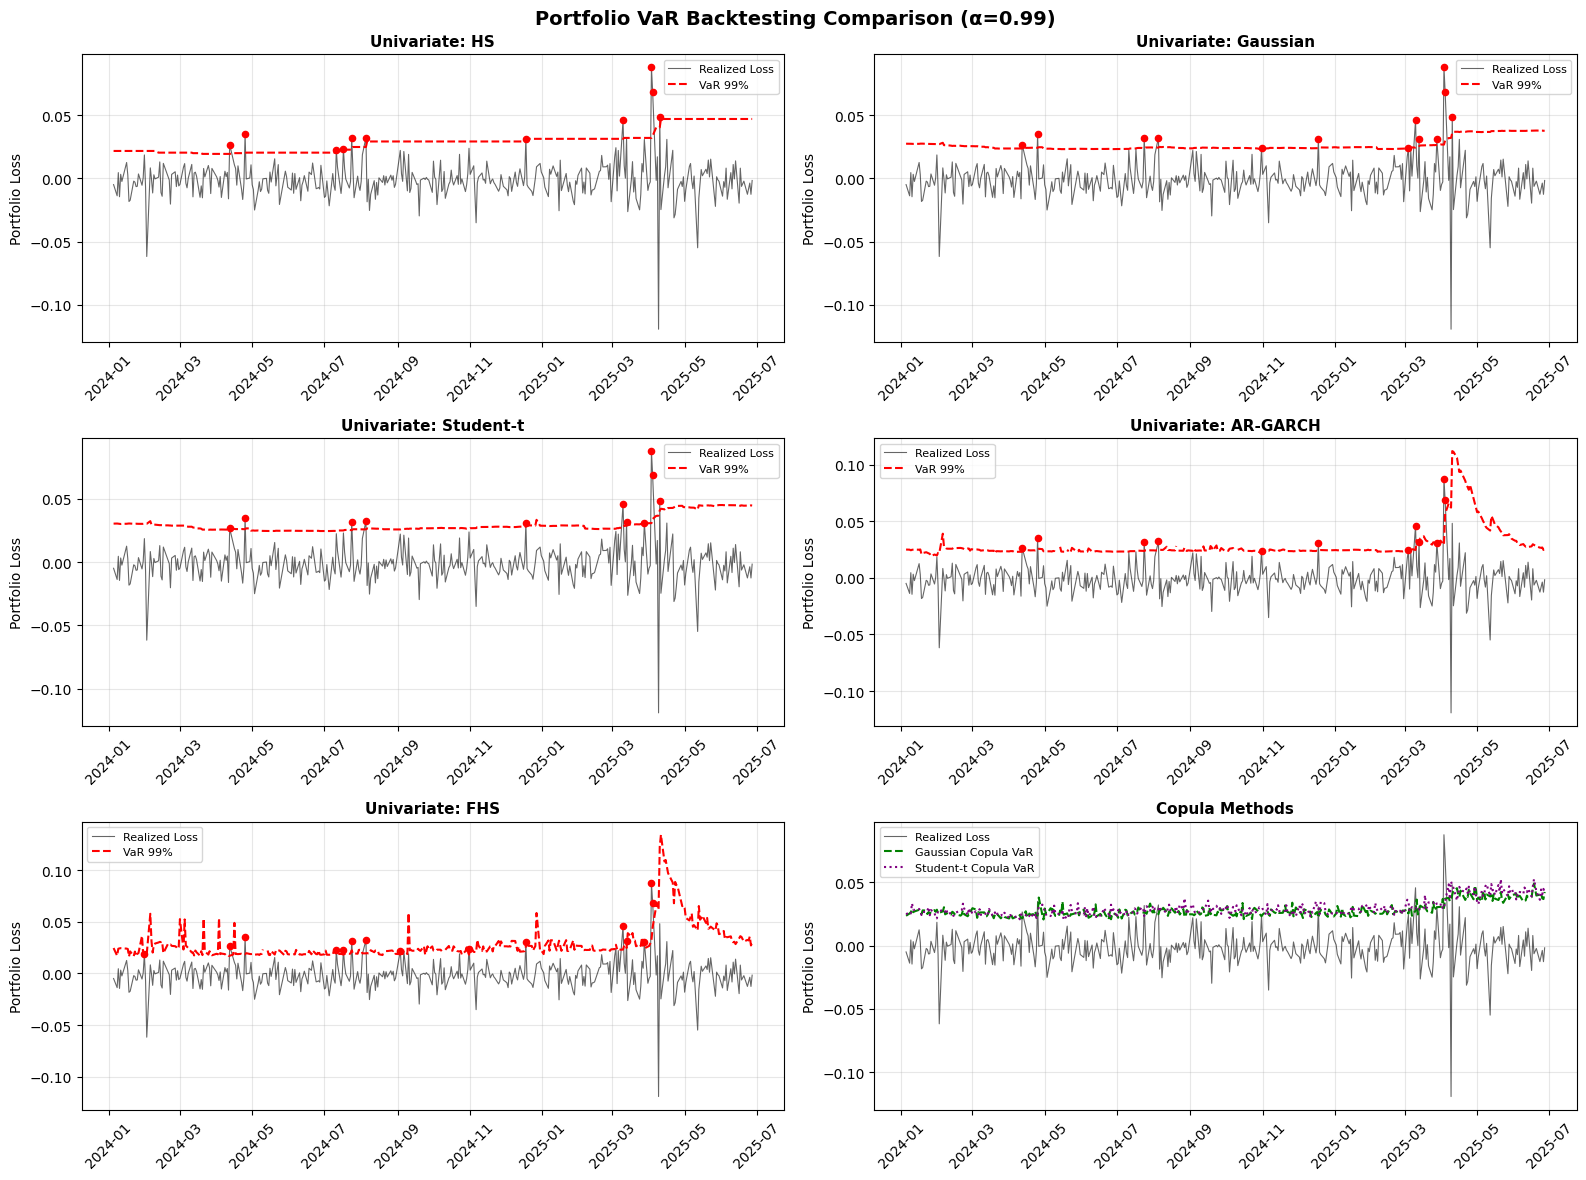


ANALYSIS: DOES DEPENDENCE MODELING IMPROVE RESULTS?

Key Observations:

1. COVERAGE ACCURACY:
   - Compare violation rates to nominal level (1-α)
   - Methods passing POF test have appropriate coverage

2. INDEPENDENCE (CC test):
   - Passing CC test → violations are independent (not clustered)
   - Failing → systematic underestimation during crisis periods

3. TAIL RISK ESTIMATION:
   - Compare Avg_VaR and Avg_ES across methods
   - Copula methods may capture tail co-movements better

4. DEPENDENCE MODELING BENEFITS:
   - Copulas explicitly model cross-asset dependence structure
   - Student-t copula captures tail dependence (joint extremes)
   - Univariate approaches ignore diversification breakdown in tails

5. POTENTIAL REASONS FOR IMPROVEMENT (or lack thereof):
   - If copula improves → cross-asset tail dependence is significant
   - If no improvement → portfolio diversification already captured
   - Equal-weighting may reduce sensitivity to dependence structure
   - Small portfo

In [ ]:
results = run_portfolio_backtesting(log_returns, W=252, ar_order=0, N_copula=1000)
univ_fc, cop_gauss_fc, cop_t_fc, realized, dates = results
